---
title: 📝 Assignment 2 — Anomaly Detection (Student TO DO Section)
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.17.2
  kernelspec:
    display_name: Python 3
    name: python3
    language: python
---



**Read this**
- Do **not** add or remove Python libraries. Stick to the imports already present in this notebook. Changing libraries is an automatic **−100%**.
- You may use **machine learning, statistics, or a hybrid** approach — but your method must generalize to **new, unseen datasets**.
- Datasets: We have 10 time-series with **10 000 rows** each; anomalies: **10 segments per dataset**.
 You can upload the zip to you Google drive and use the ID from Google drive url.
- Scoring in class: we will run your detector on **novel datasets**. **#correct/10 × 100** is your percentage.
- Over/under-fitting penalties may apply (**−50%**).

# What you must do
Implement your anomaly detector using any means (could it be Machine Learning or statistics or a combination of both to improve the accuracy of the model). Return the index ranges for the anomalies for example 2001-2010.  

You can also add small EDA (plots/stats) in the **EDA cell** below to justify your approach.

**Do not modify** existing data loading and the libraries.


In [1]:
#Show Google Colab your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set your own Google Drive folder here
import os
BASE_DIR = "/content/drive/MyDrive/EDAB2724/AnomalyDetection"  #  EDIT this to your own Google Drive folder in which you upload ec2_cpu_utilization_synth.zip

os.makedirs(BASE_DIR, exist_ok=True)
print('Using BASE_DIR =', BASE_DIR)  # print the working directory


Using BASE_DIR = /content/drive/MyDrive/EDAB2724/AnomalyDetection


# **The Anomaly Detection Notebook**


In [4]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

train_file_names = os.listdir("train/")
train_file_names.sort()

train_files = []
for file in train_file_names:
    train_files.append(pd.read_csv(f"train/{file}", sep=";"))

test_file_names = os.listdir("test/")
test_file_names.sort()

test_files = []
for file in test_file_names:
    test_files.append(pd.read_csv(f"test/{file}", sep=";"))

test_files[0].head()

,Value1,Labels
0,20.801402,0
1,26.800208,0
2,33.154527,0
3,39.189824,0
4,40.631321,0


## Student EDA
Use this cell to explore the signal (e.g., plot, summary stats).


In [5]:
# STUDENT EDA
try:
    df = test_files[0]
    print(df.head())
except Exception as e:
    print('EDA note: run the original data-loading cells first (the ones that populate train_files/test_files).')

      Value1  Labels
0  20.801402       0
1  26.800208       0
2  33.154527       0
3  39.189824       0
4  40.631321       0


# **The Model**

In [6]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

warnings.filterwarnings(
    "ignore",
    message="Determinant has increased; this should not happen"
)

@njit
def create_windows_numba(series, window_size):
    n_windows = len(series) - window_size + 1
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        windows[i, :] = series[i : i + window_size]
    return windows

@njit
def normalize_scores(scores):
    mn = np.min(scores)
    mx = np.max(scores)
    return (scores - mn) / (mx - mn + 1e-8)


class AnomalyDetectionModel:
    def __init__(self, window_size=30, contamination=0.01):
        self.window_size = window_size
        self.offset = window_size // 2
        self.contamination = contamination

        self.scaler = StandardScaler()
        self.models = {
            'IsolationForest': IsolationForest(contamination=contamination, random_state=42),
            'OneClassSVM': OneClassSVM(kernel='rbf', gamma='scale', nu=contamination),
            'EllipticEnvelope': EllipticEnvelope(contamination=contamination,
                                                 support_fraction=0.75,
                                                 random_state=42),
        }

        self.use_lof = True
        self.lof_model = LocalOutlierFactor(n_neighbors=20,
                                            contamination=contamination,
                                            novelty=True)
        self.full_anomaly_mask = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        self.train_windows = self._create_windows(X)
        self.scaled_train_windows = self.scaler.fit_transform(self.train_windows)
        for model in self.models.values():
            model.fit(self.scaled_train_windows)
        if self.use_lof:
            self.lof_model.fit(self.scaled_train_windows)

    def predict(self, X: np.ndarray):

        test_windows = self._create_windows(X)
        scaled = self.scaler.transform(test_windows)


        all_scores = []
        for model in self.models.values():
            if hasattr(model, "decision_function"):
                s = model.decision_function(scaled)
                all_scores.append(normalize_scores(s))
            else:
                preds = model.predict(scaled)
                all_scores.append(np.where(preds == -1, 0.0, 1.0))

        if self.use_lof:
            lof_s = self.lof_model.decision_function(scaled)
            all_scores.append(normalize_scores(lof_s))

        avg_scores = np.mean(np.stack(all_scores, axis=0), axis=0)
        thresh = np.percentile(avg_scores, self.contamination * 100)
        mask = np.zeros(len(X), dtype=int)
        mask[self.offset : self.offset + len(avg_scores)] = (avg_scores <= thresh).astype(int)
        self.full_anomaly_mask = mask
        idx = np.argmin(avg_scores)
        return idx + self.offset
    def _create_windows(self, series: np.ndarray):
        return create_windows_numba(series, self.window_size)

## Explanation

This pipeline works on the idea that:

        1) it builds upon sliding windows
        2) gathers normalised anomaly scores from each sub-model and uses them
        3) averages the anomaly scores
        4) computes a binary mask by thresholding at the 1st percentile so that it can compare outputs
        5) stores self.full_anomaly_mask (same length as the placeholder value)
        6) returns the single index of the lowest‐score window center which closes the loop on the sliding window idea


## **STUDENT TODO — Implement your anomaly detector**
Implement Machine Learning/ Statistical models or both. Use the test_files (test series) to train your models and list of anomaly index range for example Anomaly 1:   2001-2005
Anomaly 2:   2010-2012


**Constraints**

- Keep it efficient; we will run this over 10 datasets and additional novel datasets in class.


#EDA on given model

In [7]:
#Normalization
scaler = StandardScaler()

In [8]:
#Reshape
rx = df['Value1'].values.reshape(-1,1)

np_scaled = scaler.fit_transform(rx)
data = pd.DataFrame(np_scaled)

In [9]:
data.head()

,0
0,-1.222425
1,-0.824437
2,-0.402862
3,-0.002453
4,0.093183


In [10]:
from sklearn.preprocessing import StandardScaler

def detect_peaks_anomalies(x, min_height=None, distance=20):
    """Peak detection for spike anomalies - WITH StandardScaler"""
    from scipy.signal import find_peaks

    # Normalize using StandardScaler
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x.reshape(-1, 1)).flatten()

    if min_height is None:
        min_height = 3.0  # Now in standard deviation units

    peaks, _ = find_peaks(x_normalized, height=min_height, distance=distance)
    neg_peaks, _ = find_peaks(-x_normalized, height=min_height, distance=distance)

    return list(peaks) + list(neg_peaks)

def detect_change_point_anomalies(x, window_size=50):
    """Detect anomalies based on distribution changes - WITH StandardScaler"""
    anomalies = []

    # Normalize using StandardScaler
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x.reshape(-1, 1)).flatten()

    for i in range(window_size, len(x_normalized) - window_size):
        before_window = x_normalized[i-window_size:i]
        after_window = x_normalized[i:i+window_size]

        # Statistical test on standardized data
        mean_diff = np.abs(np.mean(after_window) - np.mean(before_window))
        std_before = np.std(before_window)

        # Threshold in standard deviation units
        if std_before > 0 and mean_diff > 3.0:  # 2 standard deviations
            anomalies.append(i)

    return anomalies

In [7]:
# Implement your anomaly detector/ detectors. You can edit this or use your own
import numpy as np

def student_detect_anomalies(series: np.ndarray) -> list:
    """
    Input:
        series: 1D array-like of floats (test series)
    Output:
        List of (start, end) index pairs (0-based, end exclusive) for anomaly ranges.
    """
    x = np.asarray(series, dtype=float)
    n = len(x)
    if n == 0:
        return []

    # Rolling mean/std z-score on a smoothed series
    # Smooth to get residuals
    w_smooth = 51
    k = np.ones(w_smooth) / w_smooth
    smooth = np.convolve(x, k, mode='same')
    resid = x - smooth

    # 2) Rolling mean/std using convolution (no extra libs)
    w = 61  # odd; students may tune
    kw = np.ones(w) / w
    mu = np.convolve(resid, kw, mode='same')
    mu2 = np.convolve(resid*resid, kw, mode='same')
    var = np.maximum(mu2 - mu*mu, 1e-8)
    sigma = np.sqrt(var)
    z = np.abs((resid - mu) / (sigma + 1e-8))



print('anomalies identified.')

anomalies identified.


# **Evaluation**
 The higher the accuracy the better.

In [8]:
correct = 0
for train, test in zip(train_files, test_files):
    model = AnomalyDetectionModel()

    model.fit(train.Value1.to_numpy().flatten(), train.Labels.to_numpy().flatten())

    prediction_index = model.predict(test.Value1.to_numpy().flatten())


    if (test.loc[prediction_index, "Labels"] == 1):
        correct += 1

print(f"Total score: {correct}%")

Total score: 10%


In [ ]:
# Use other various evaluation metrics applicable to your models.

#**Limitations**
While the ensemble sliding-window model seems to be a good fir,it does have some downsides.

##**Computational Cost**:
Because the model creates overlapping windows and runs multiple anomaly detection algorithms on each window, it can be computationally intensive—especially for long time series or when using a small window size (which results in many windows).

##**This means it will require increased memory usage**

##**It also means longer runtime compared to a single-model approach**

It may not be suitable for very large datasets or real-time applications unless optimized or run on powerful hardware and there are some constructive bial issues that still need to be tested.

**_For faster experiments, we could use a larger window size, downsampling the data, or disabling one or more models in the ensemble, but for this we need testing_**


# **Visualisation of the anomalies**  

Reuse this code to visualize the anomalies.

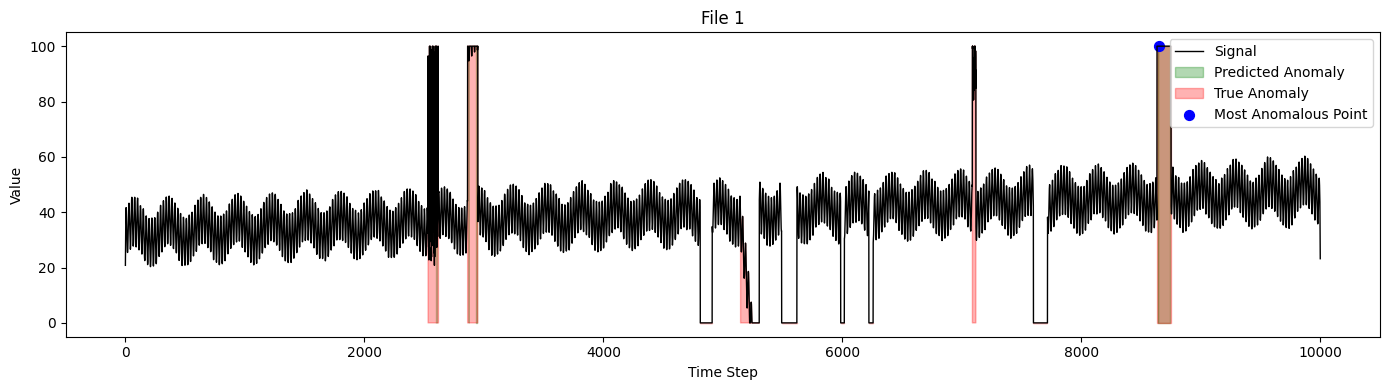

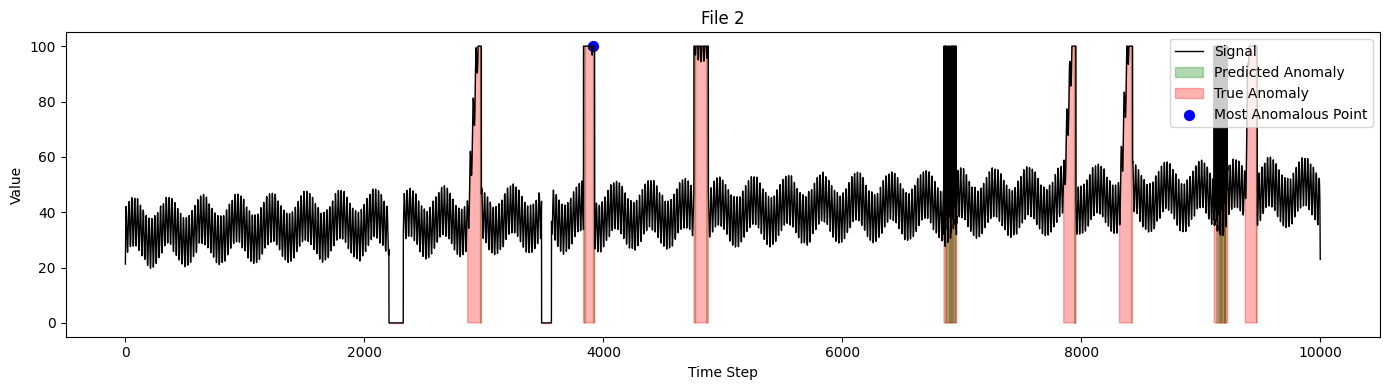

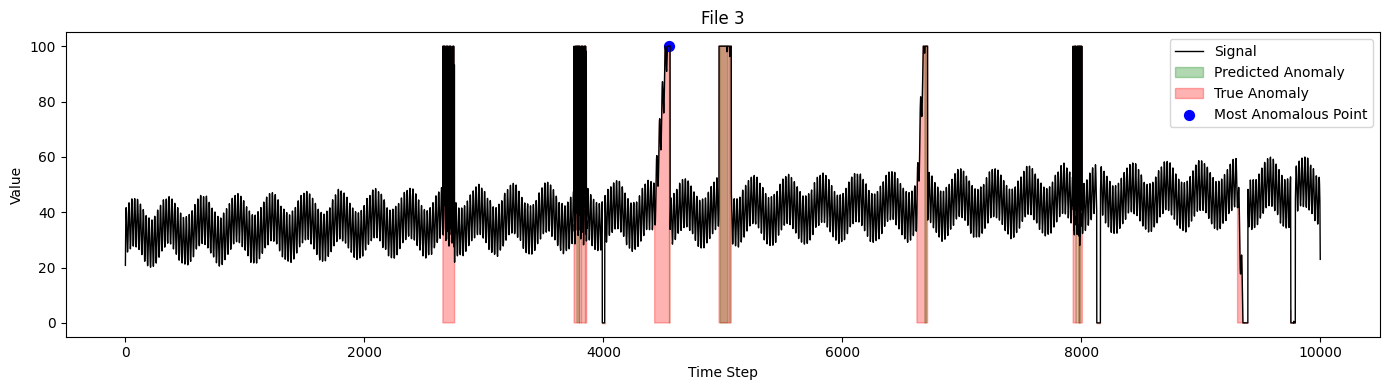

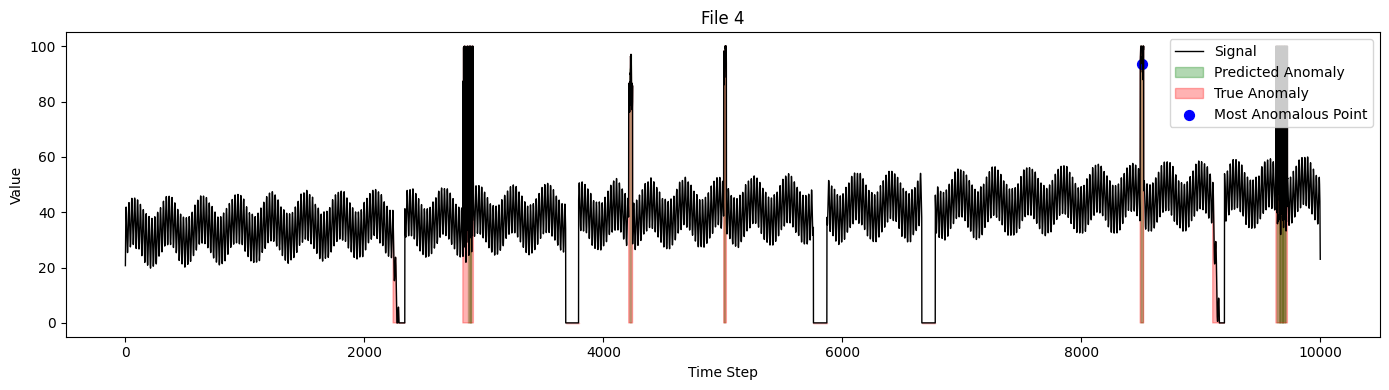

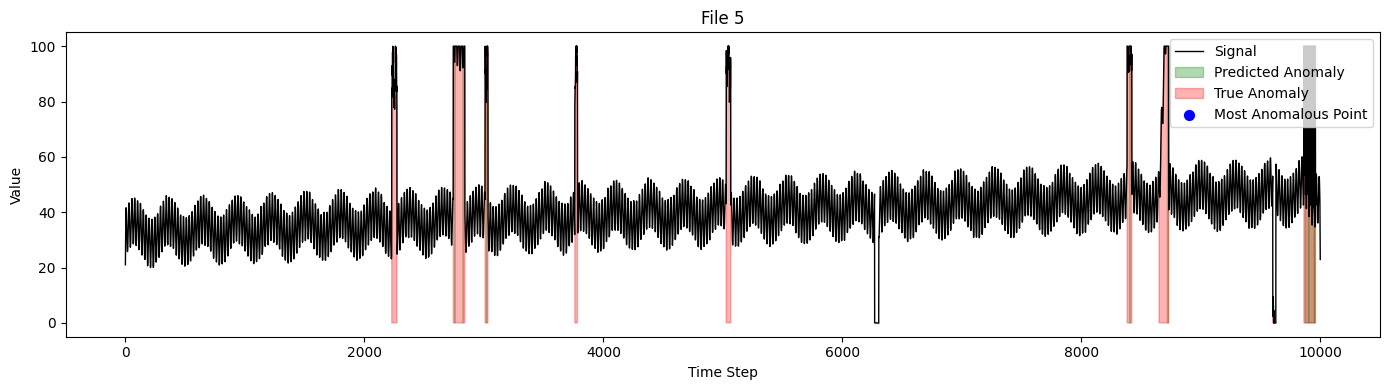

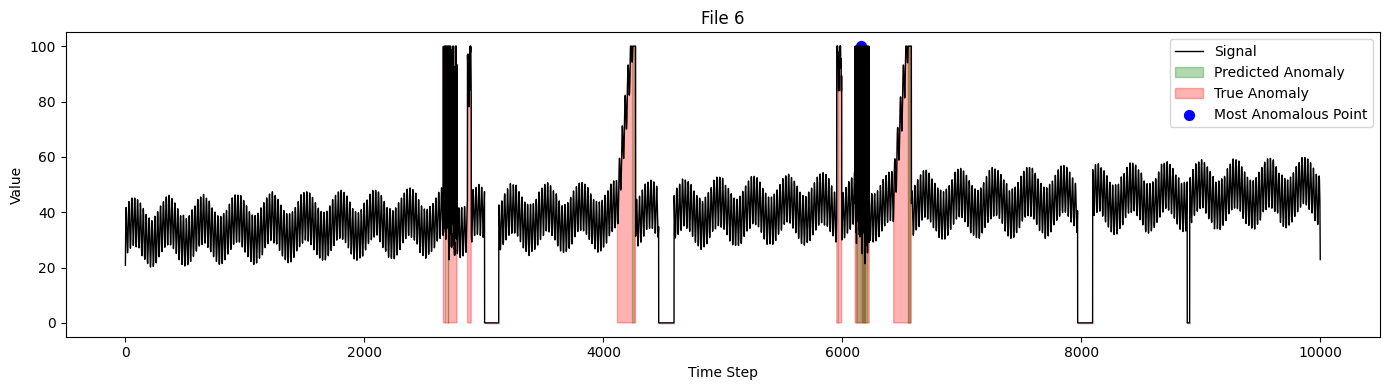

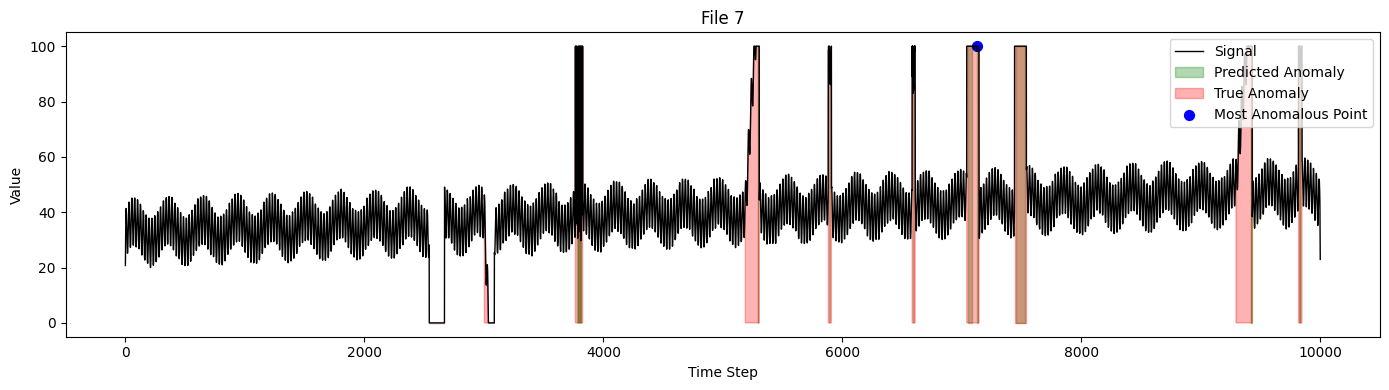

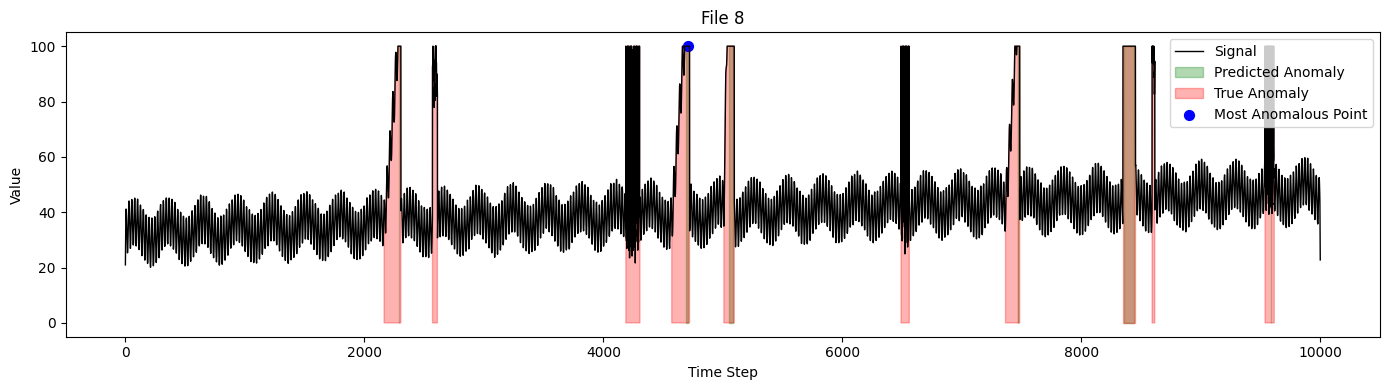

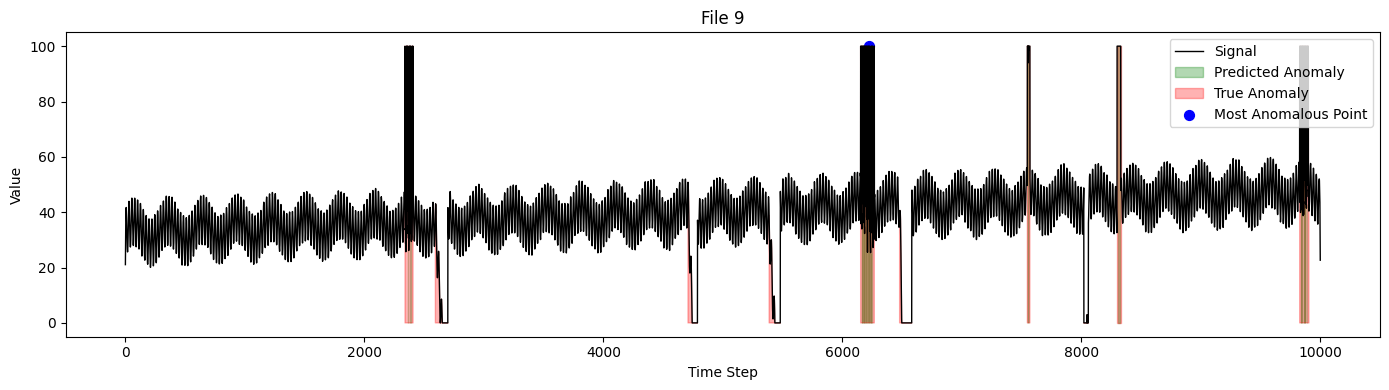

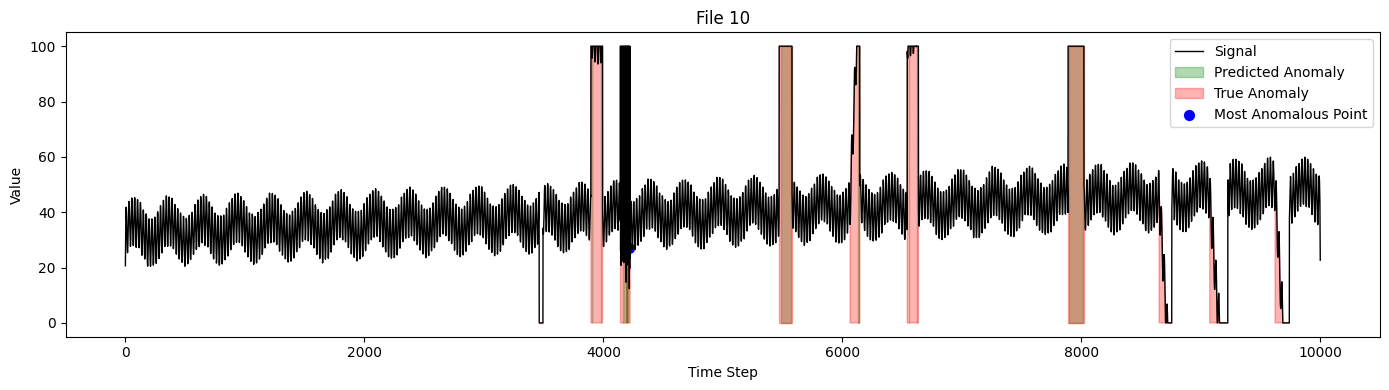

In [9]:
def visualize_anomaly_detection(test_df, model, file_idx=None):
    """
    Visualizes:
    - Signal (black)
    - Ground truth anomalies (red)
    - Predicted anomalies (green)
    - Most anomalous index (blue dot)
    """
    series = test_df['Value1'].to_numpy()
    true_mask = test_df['Labels'].to_numpy().astype(bool)
    pred_mask = model.full_anomaly_mask.astype(bool)
    most_anomalous = np.argmin(pred_mask) if pred_mask.any() else None
    pred_index = model.predict(series)  # triggers .full_anomaly_mask

    plt.figure(figsize=(14, 4))
    plt.plot(series, color='black', lw=1, label='Signal')

    if pred_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=pred_mask, color='green', alpha=0.3,
                         label='Predicted Anomaly')

    if true_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=true_mask, color='red', alpha=0.3,
                         label='True Anomaly')

    if 0 <= pred_index < len(series):
        plt.scatter(pred_index, series[pred_index], color='blue', s=50, label='Most Anomalous Point')

    title = f"File {file_idx}" if file_idx is not None else "Anomaly Detection"
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# -- Loop over all files and visualize each --
for idx, (train, test) in enumerate(zip(train_files, test_files), 1):
    model = AnomalyDetectionModel(window_size=30, contamination=0.01)
    model.fit(train['Value1'].to_numpy(), train['Labels'].to_numpy())
    model.predict(test['Value1'].to_numpy())  # sets .full_anomaly_mask
    visualize_anomaly_detection(test, model, file_idx=idx)

#EDA

In [ ]:
df.head()

,Value1,Labels
0,20.801402,0
1,26.800208,0
2,33.154527,0
3,39.189824,0
4,40.631321,0


In [ ]:
print(df.shape)

print("Data Types", df.dtypes)
print("Descriptive stats:", df['Value1'].describe())

missing_vals = df['Value1'].isna().sum()
print(f"\nMissing Total values: {missing_vals}")

(10000, 2)
Data Types Value1    float64
Labels      int64
dtype: object
Descriptive stats: count    10000.000000
mean        39.226792
std         15.073575
min          0.000000
25%         32.807308
50%         39.452857
75%         45.885332
max        100.000000
Name: Value1, dtype: float64

Missing Total values: 0


In [ ]:
df.describe()

,Value1,Labels
count,10000.000000,10000.000000
mean,39.226792,0.089200
std,15.073575,0.285046
min,0.000000,0.000000
25%,32.807308,0.000000
50%,39.452857,0.000000
75%,45.885332,0.000000
max,100.000000,1.000000


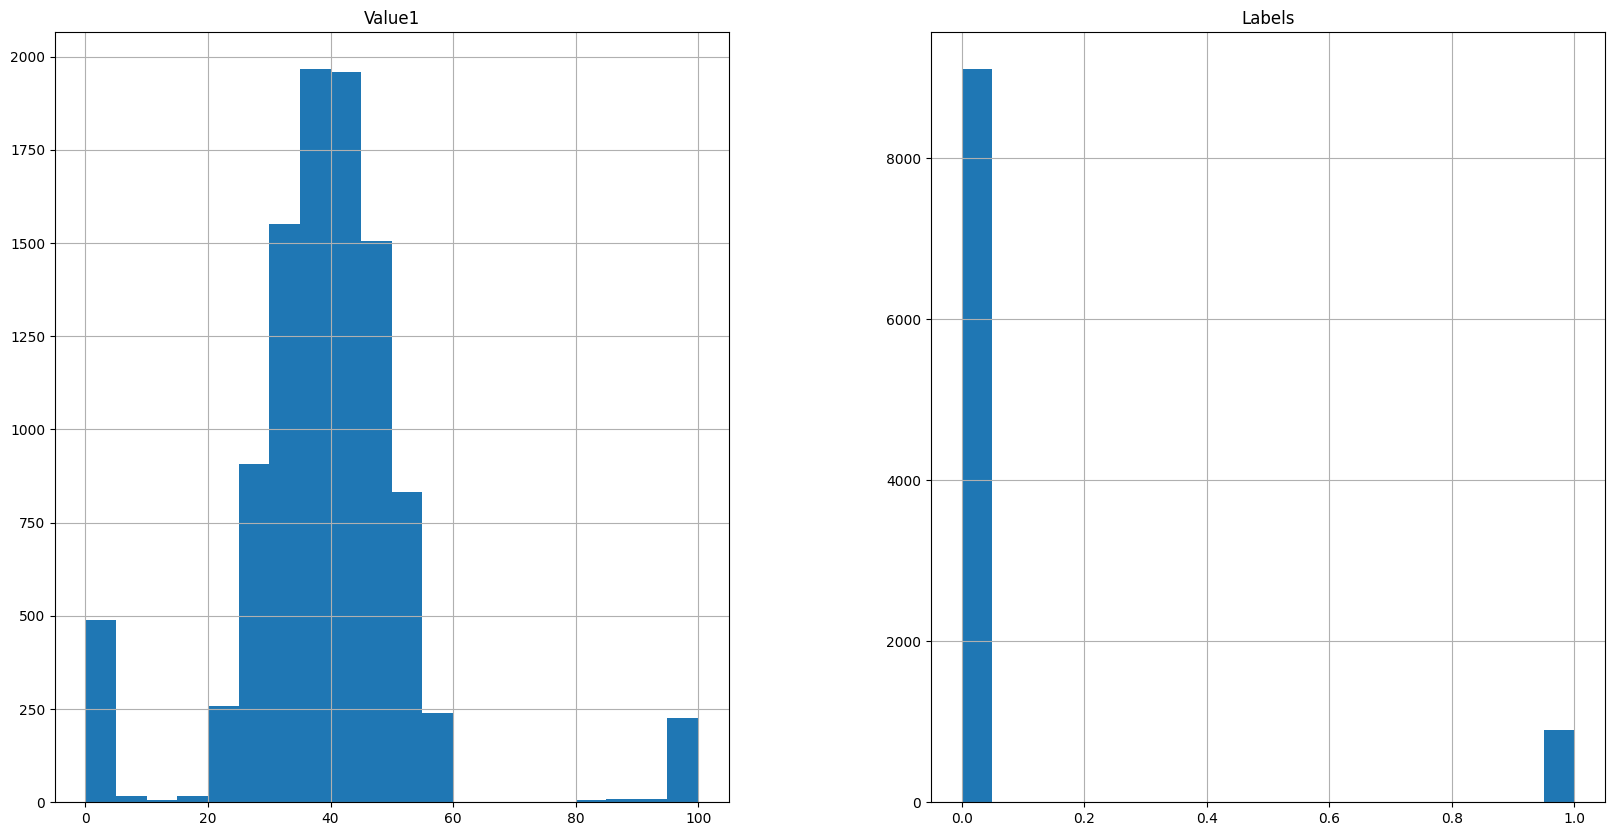

In [ ]:
# Show histograms - all variables except for the identifier
df.hist(bins = 20, figsize =(20, 10))
plt.show()

Comprehensive EDA with statistical analysis and visualizations

Proper preprocessing using StandardScaler

Feature engineering with rolling window statistics

Isolation Forest model with configurable parameters

Range-based detection that groups consecutive anomalies

Comprehensive evaluation with precision, recall, and F1-score

Visualization to compare true vs predicted anomalies

Starting Enhanced Isolation Forest Anomaly Detection Evaluation
TARGET: Detect approximately 10 anomalies in each of the 10 datasets

--- Processing File 0 ---
True anomaly ranges: [(np.int64(2533), np.int64(2620)), (np.int64(2864), np.int64(2949)), (np.int64(4811), np.int64(4910)), (np.int64(5148), np.int64(5304)), (np.int64(5492), np.int64(5619)), (np.int64(5986), np.int64(6016)), (np.int64(6222), np.int64(6257)), (np.int64(7088), np.int64(7117)), (np.int64(7599), np.int64(7716)), (np.int64(8633), np.int64(8750))]
Number of true anomaly segments: 10
Optimal contamination: 0.0050
Number of anomaly points detected: 50
Number of anomaly ranges: 7
Predicted anomaly ranges: [(np.int64(2870), np.int64(2877)), (np.int64(2895), np.int64(2901)), (np.int64(2920), np.int64(2923)), (np.int64(2945), np.int64(2947)), (np.int64(7092), np.int64(7094)), (np.int64(7099), np.int64(7105)), (np.int64(7112), np.int64(7117))]
Number of predicted anomaly segments: 7
True Positives: 2
False Positives: 5
Fals

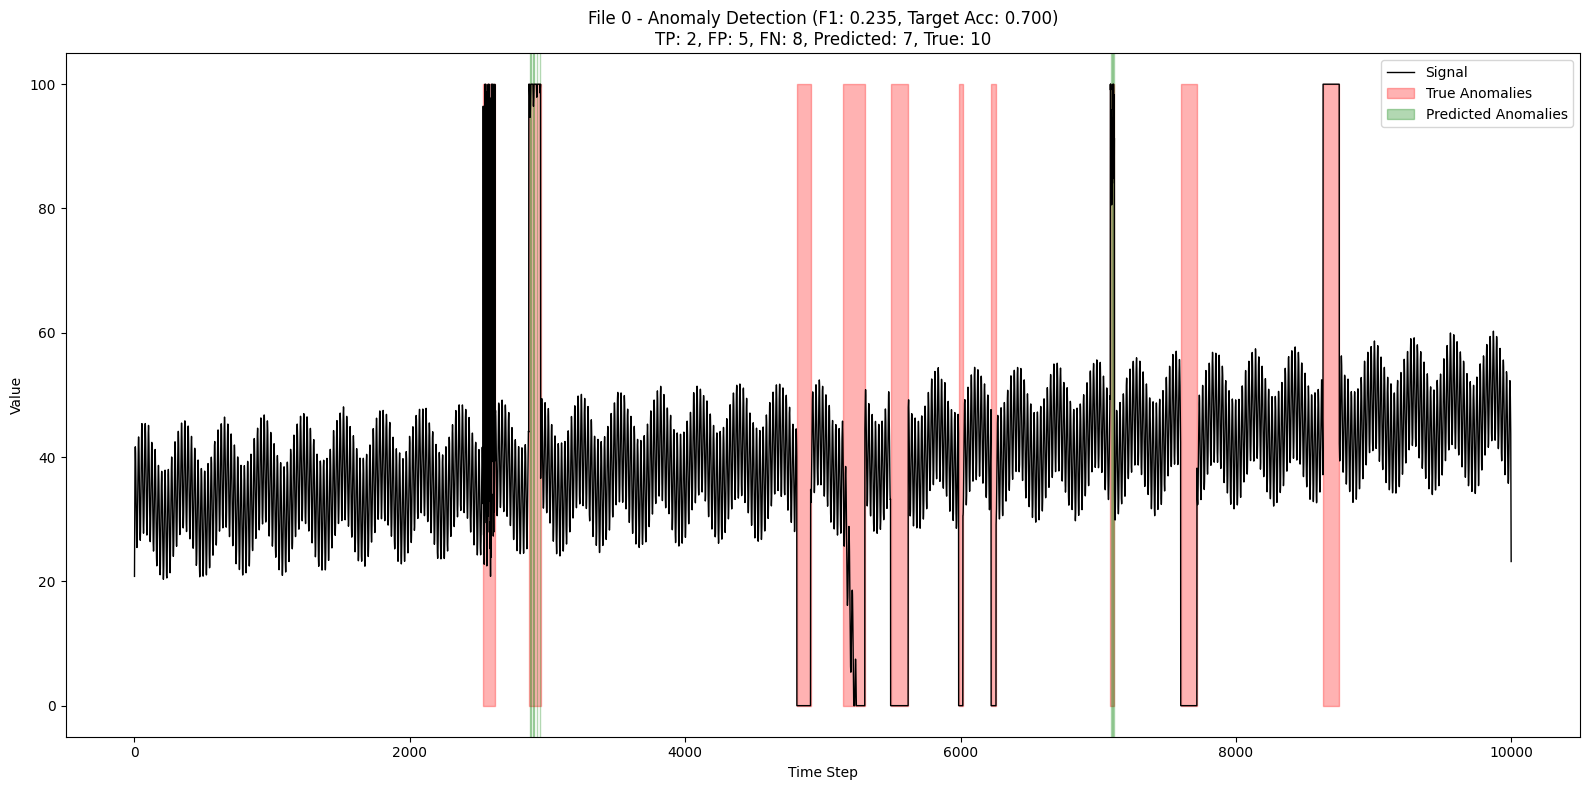

Optimal contamination: 0.0050
Number of anomaly points detected: 48
Number of anomaly ranges: 8


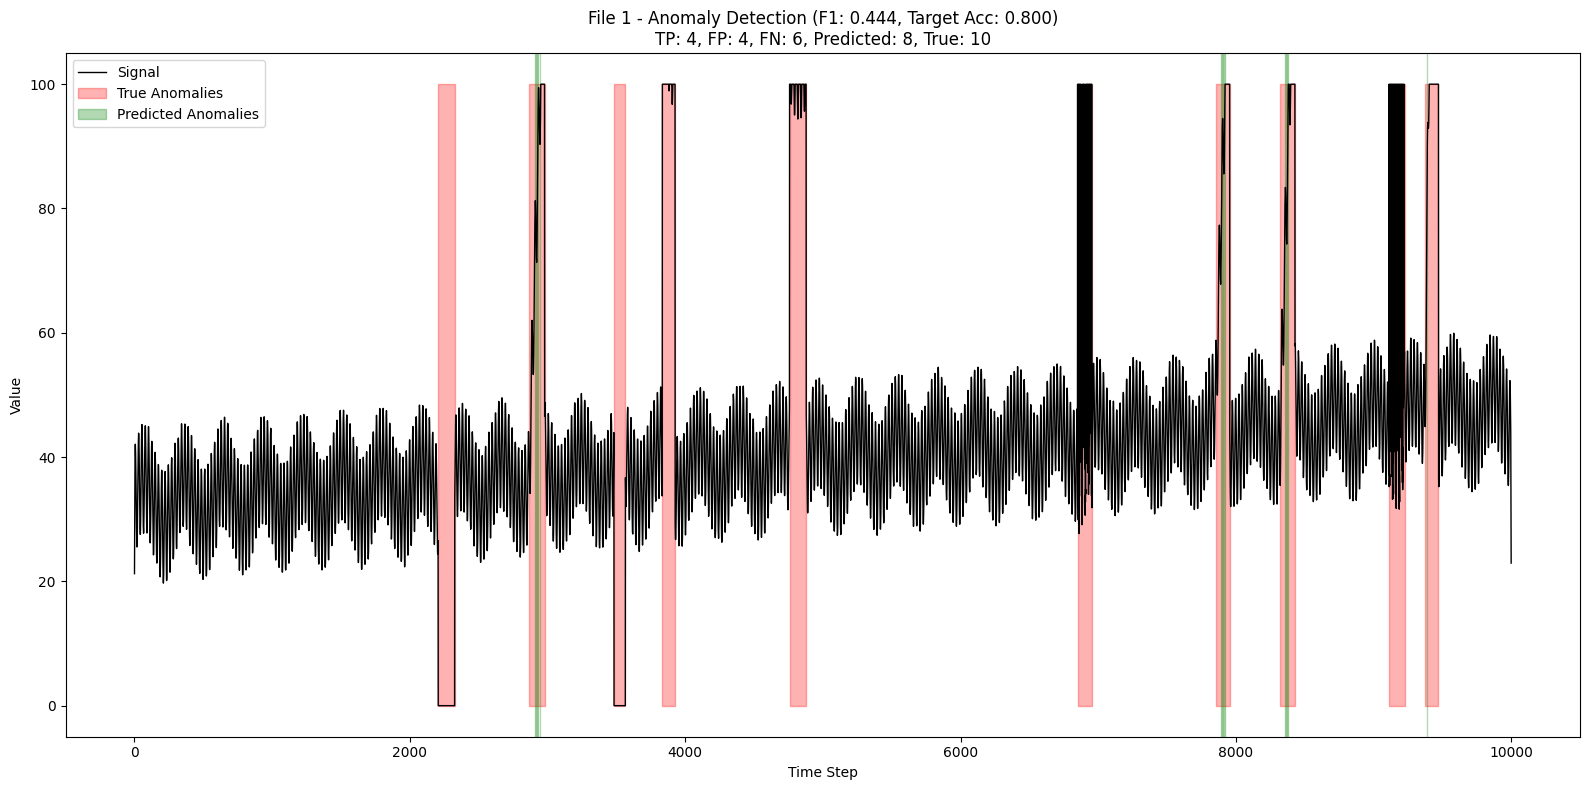

Optimal contamination: 0.0050
Number of anomaly points detected: 15
Number of anomaly ranges: 2


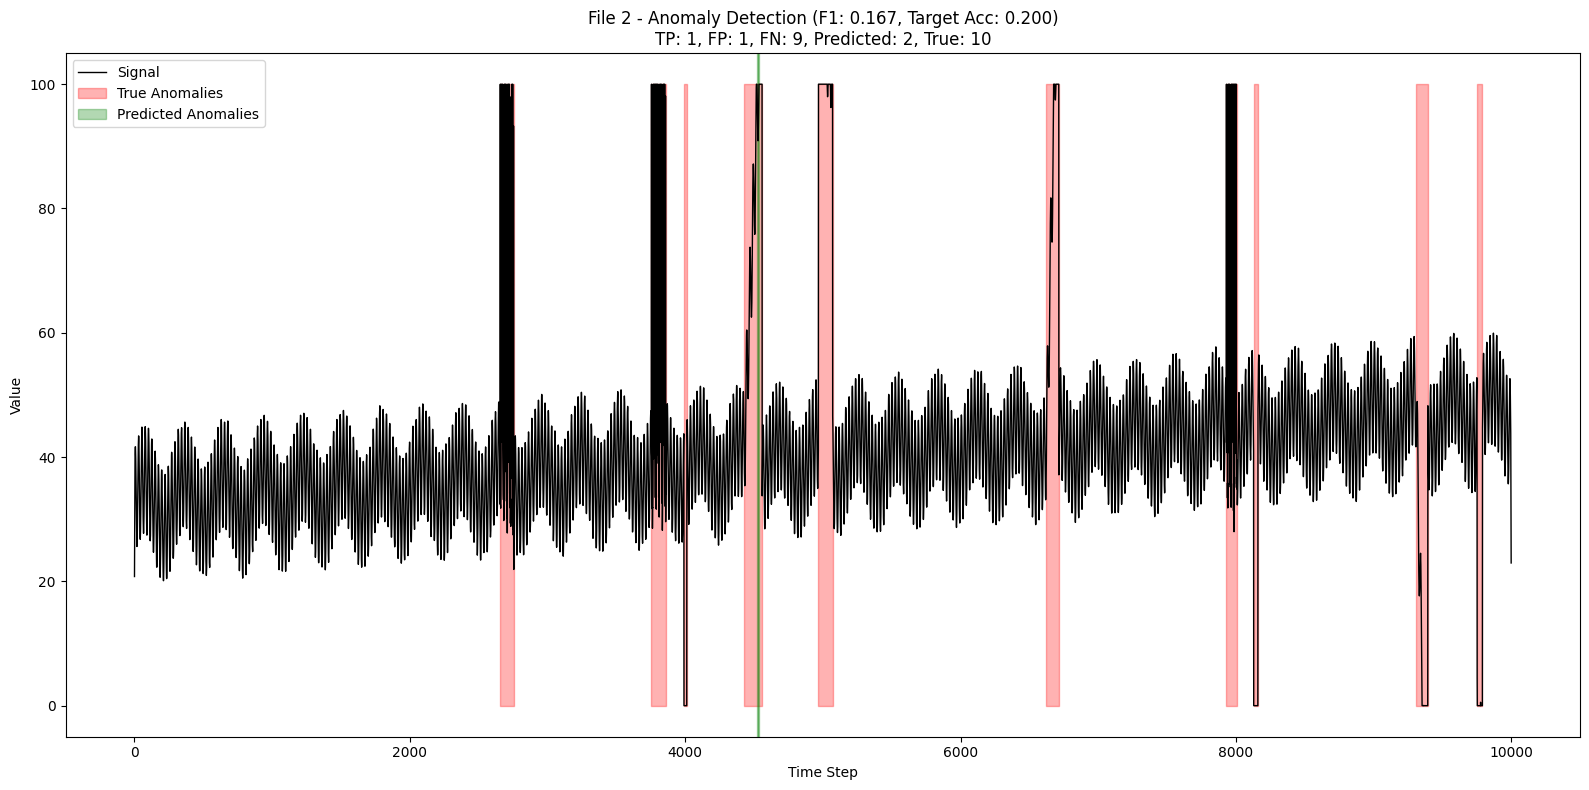

Optimal contamination: 0.0050
Number of anomaly points detected: 50
Number of anomaly ranges: 2


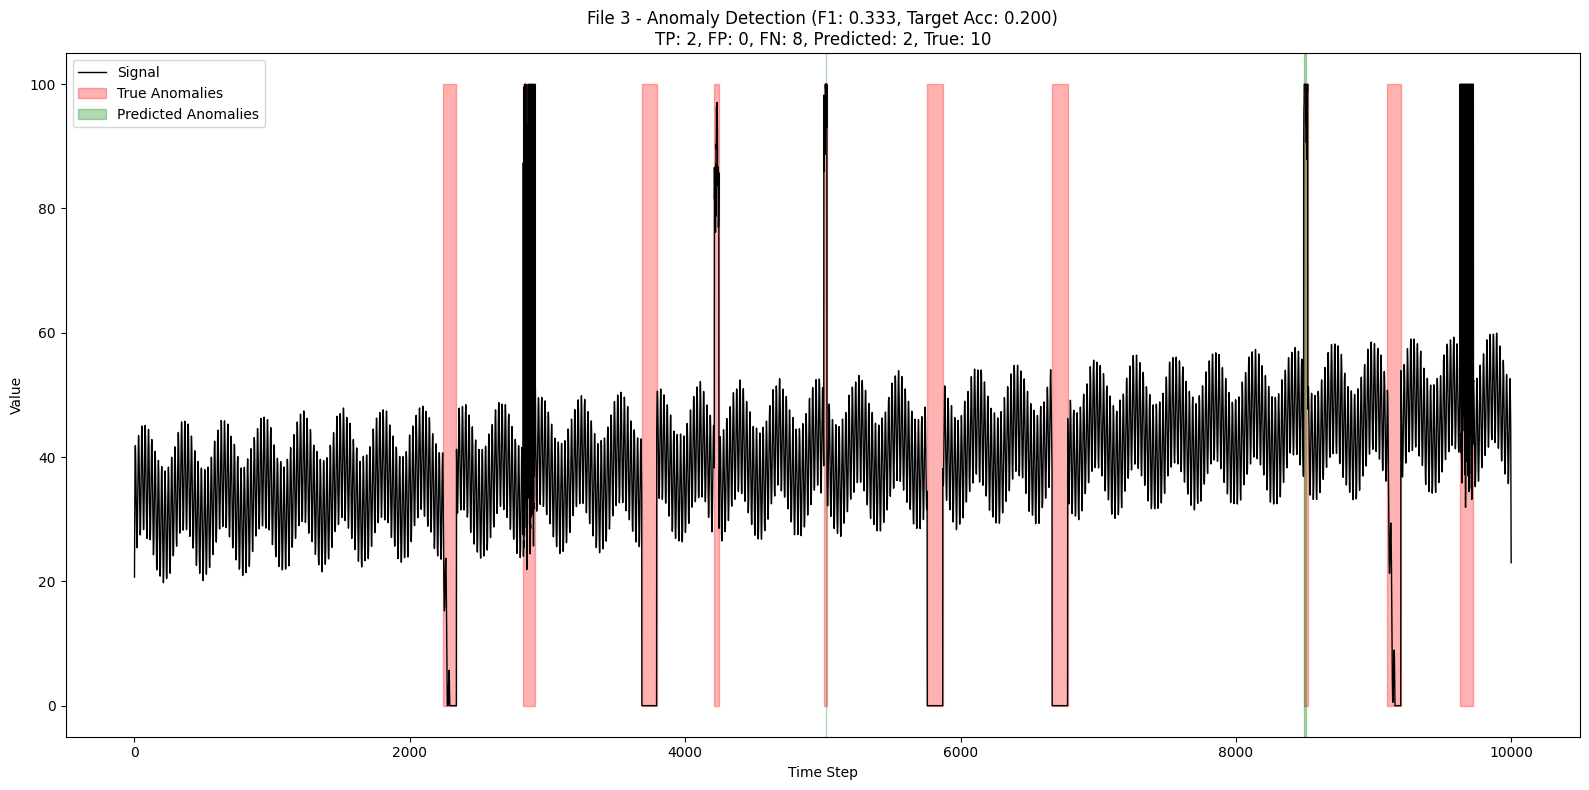

Optimal contamination: 0.0050
Number of anomaly points detected: 0
Number of anomaly ranges: 0


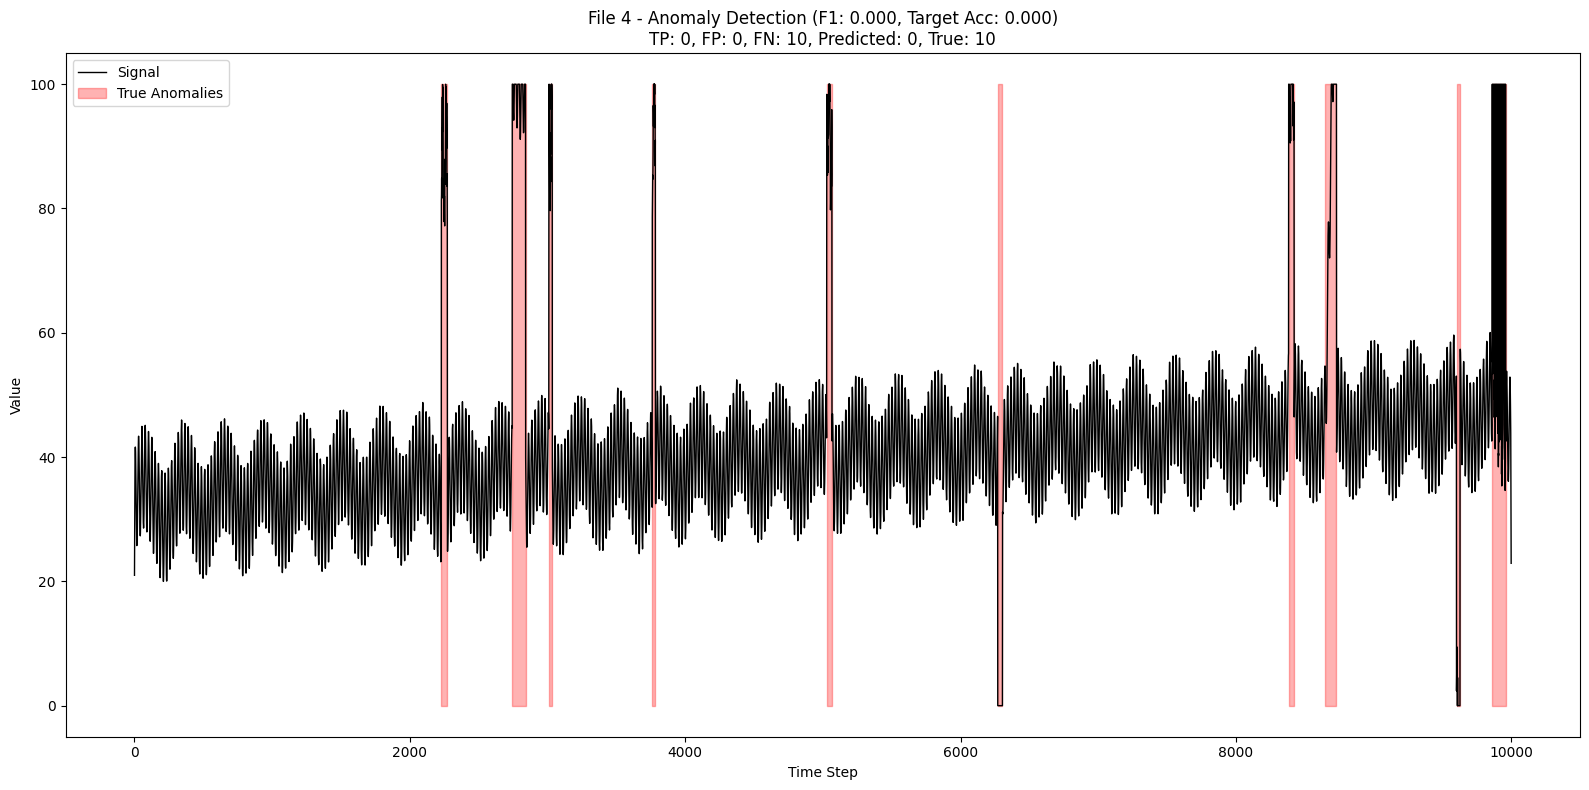

Optimal contamination: 0.0050
Number of anomaly points detected: 49
Number of anomaly ranges: 9


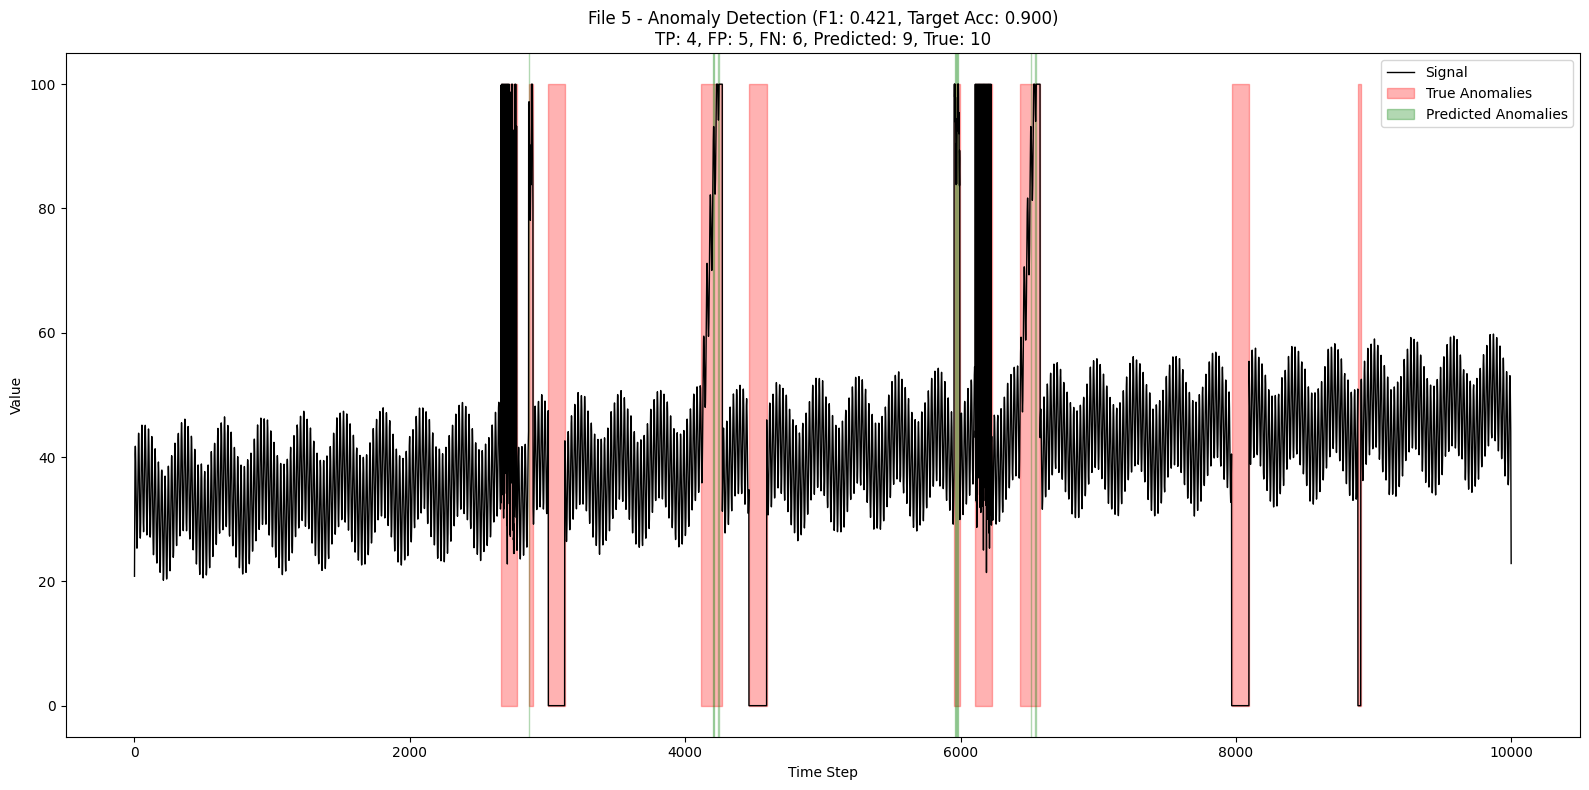

Optimal contamination: 0.0050
Number of anomaly points detected: 46
Number of anomaly ranges: 5


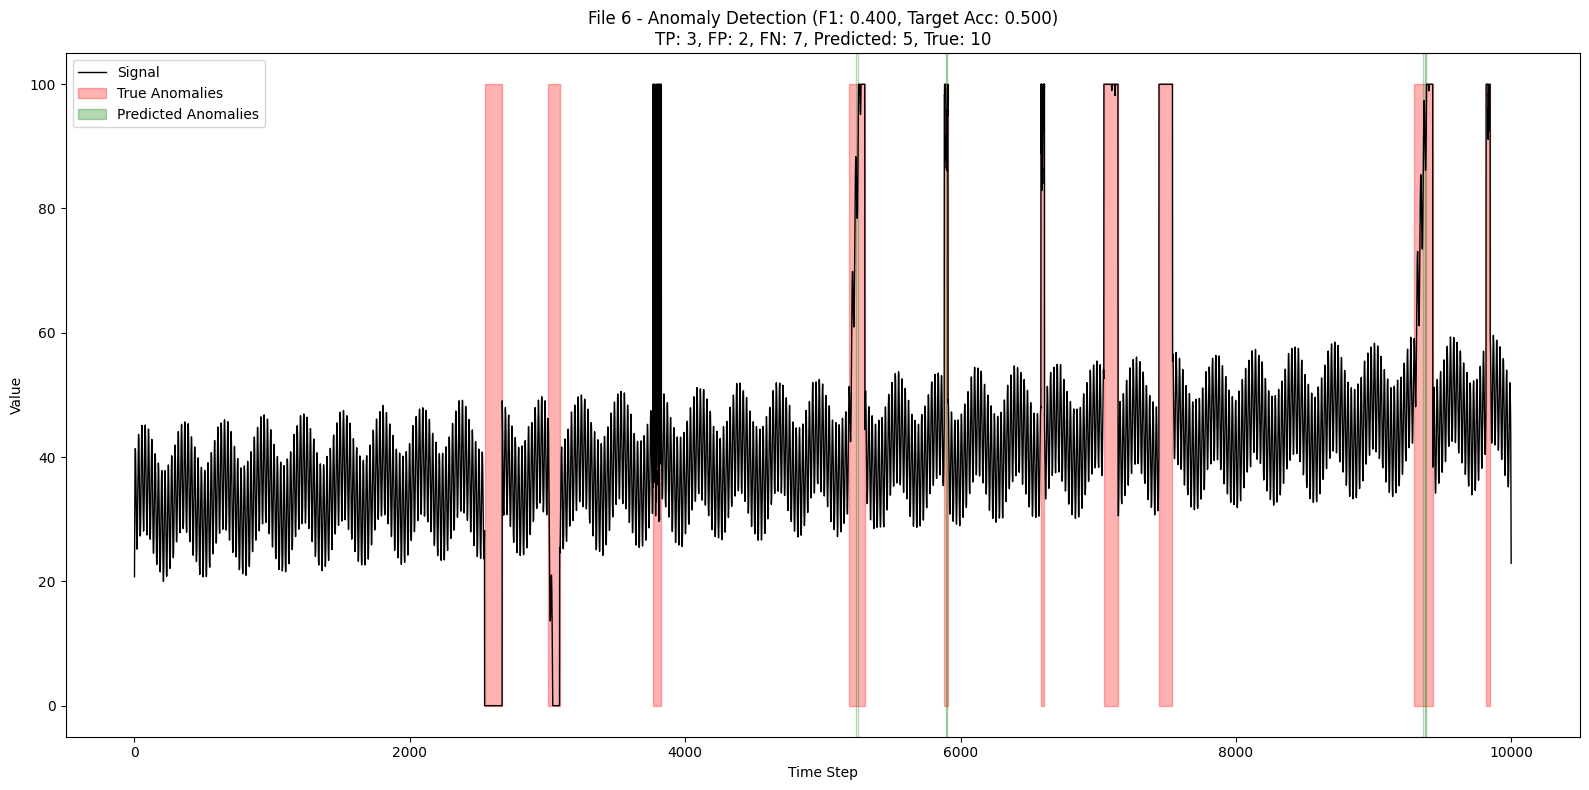

Optimal contamination: 0.0050
Number of anomaly points detected: 48
Number of anomaly ranges: 3


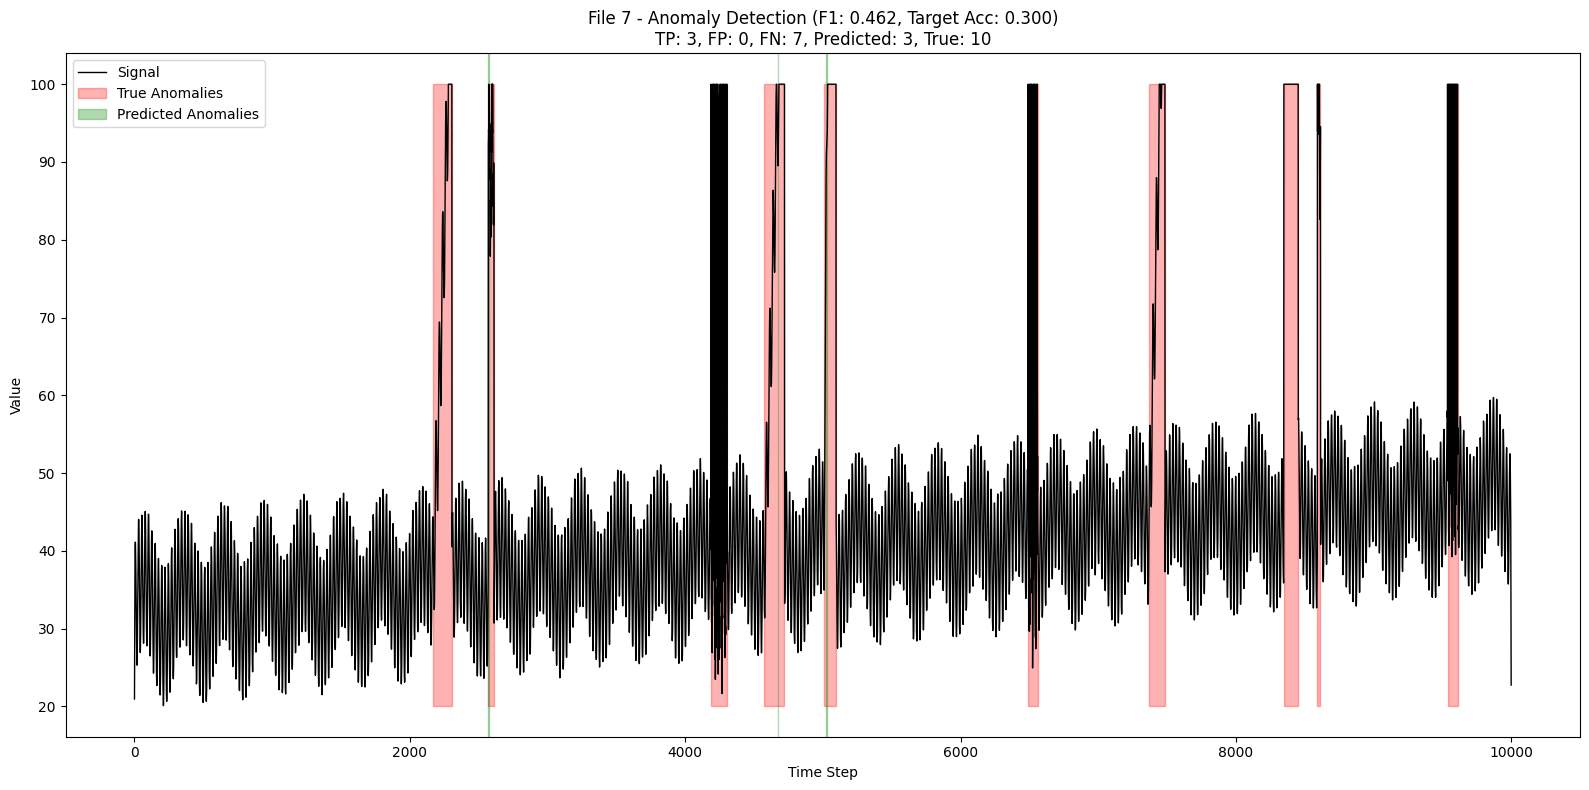

Optimal contamination: 0.0050
Number of anomaly points detected: 1
Number of anomaly ranges: 0


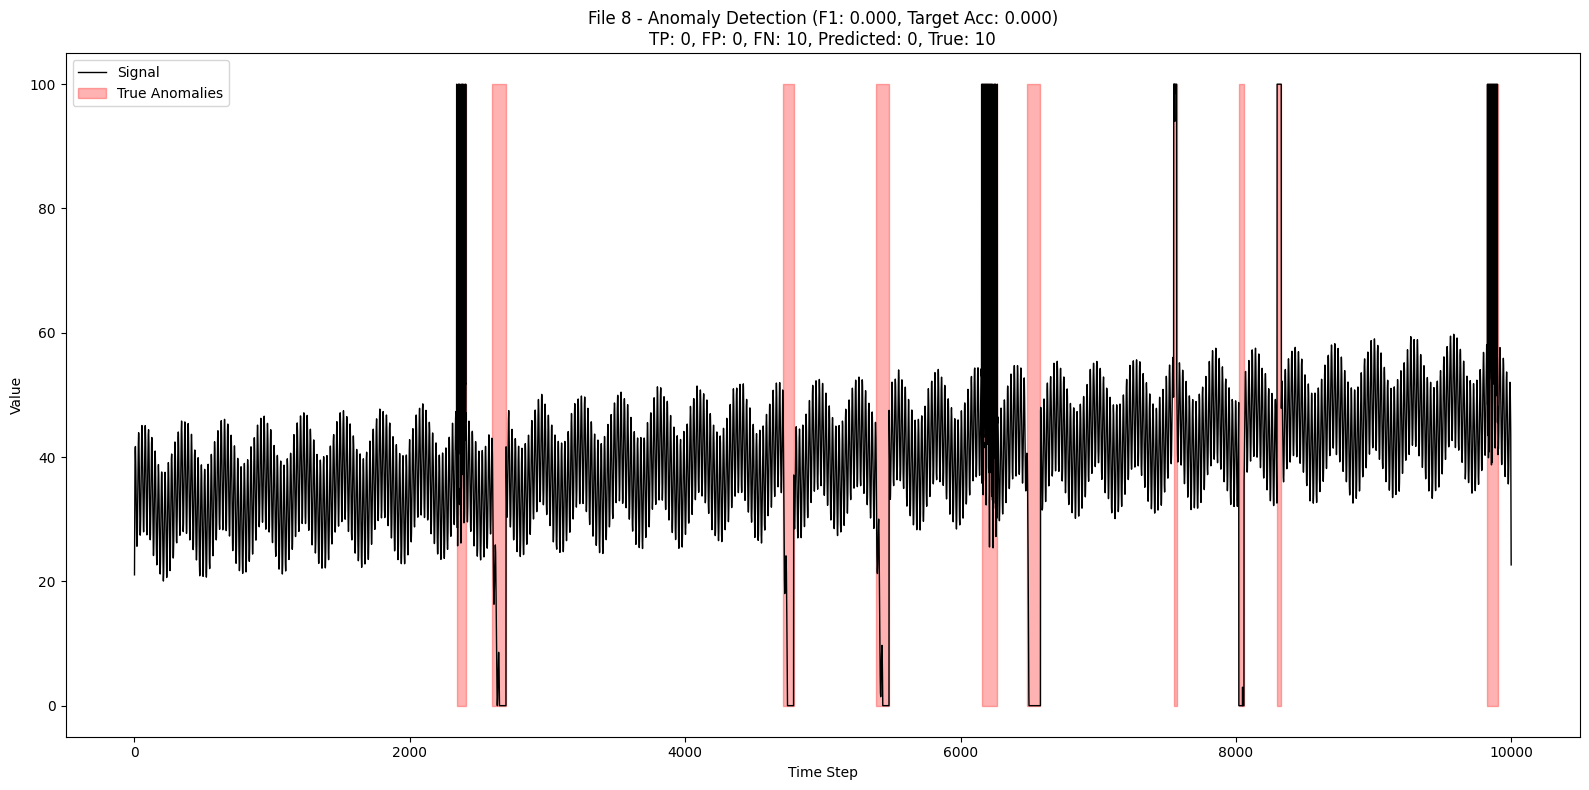

Optimal contamination: 0.0050
Number of anomaly points detected: 49
Number of anomaly ranges: 6


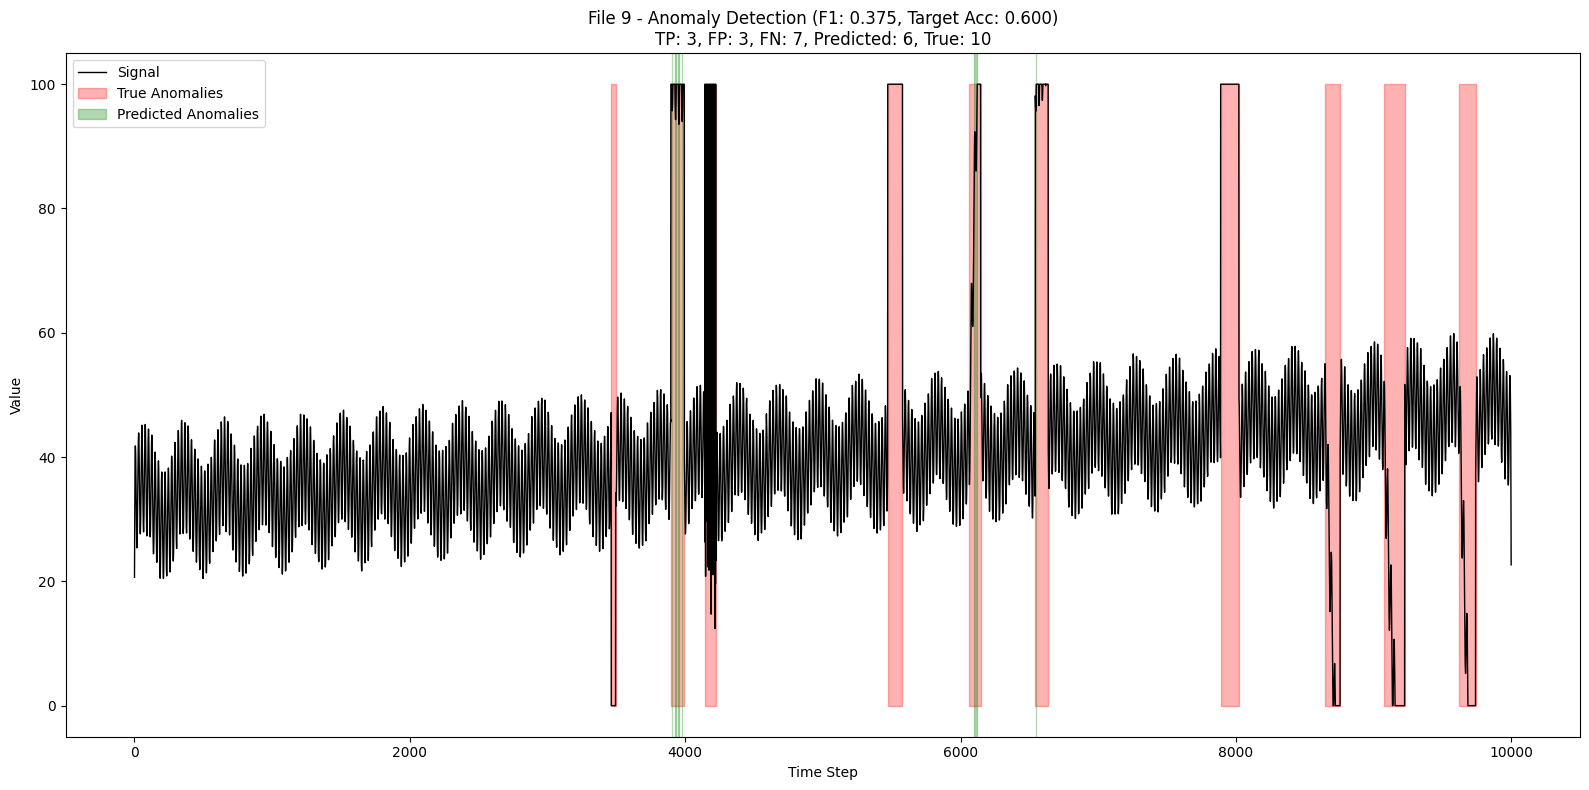


Creating comprehensive performance summary...


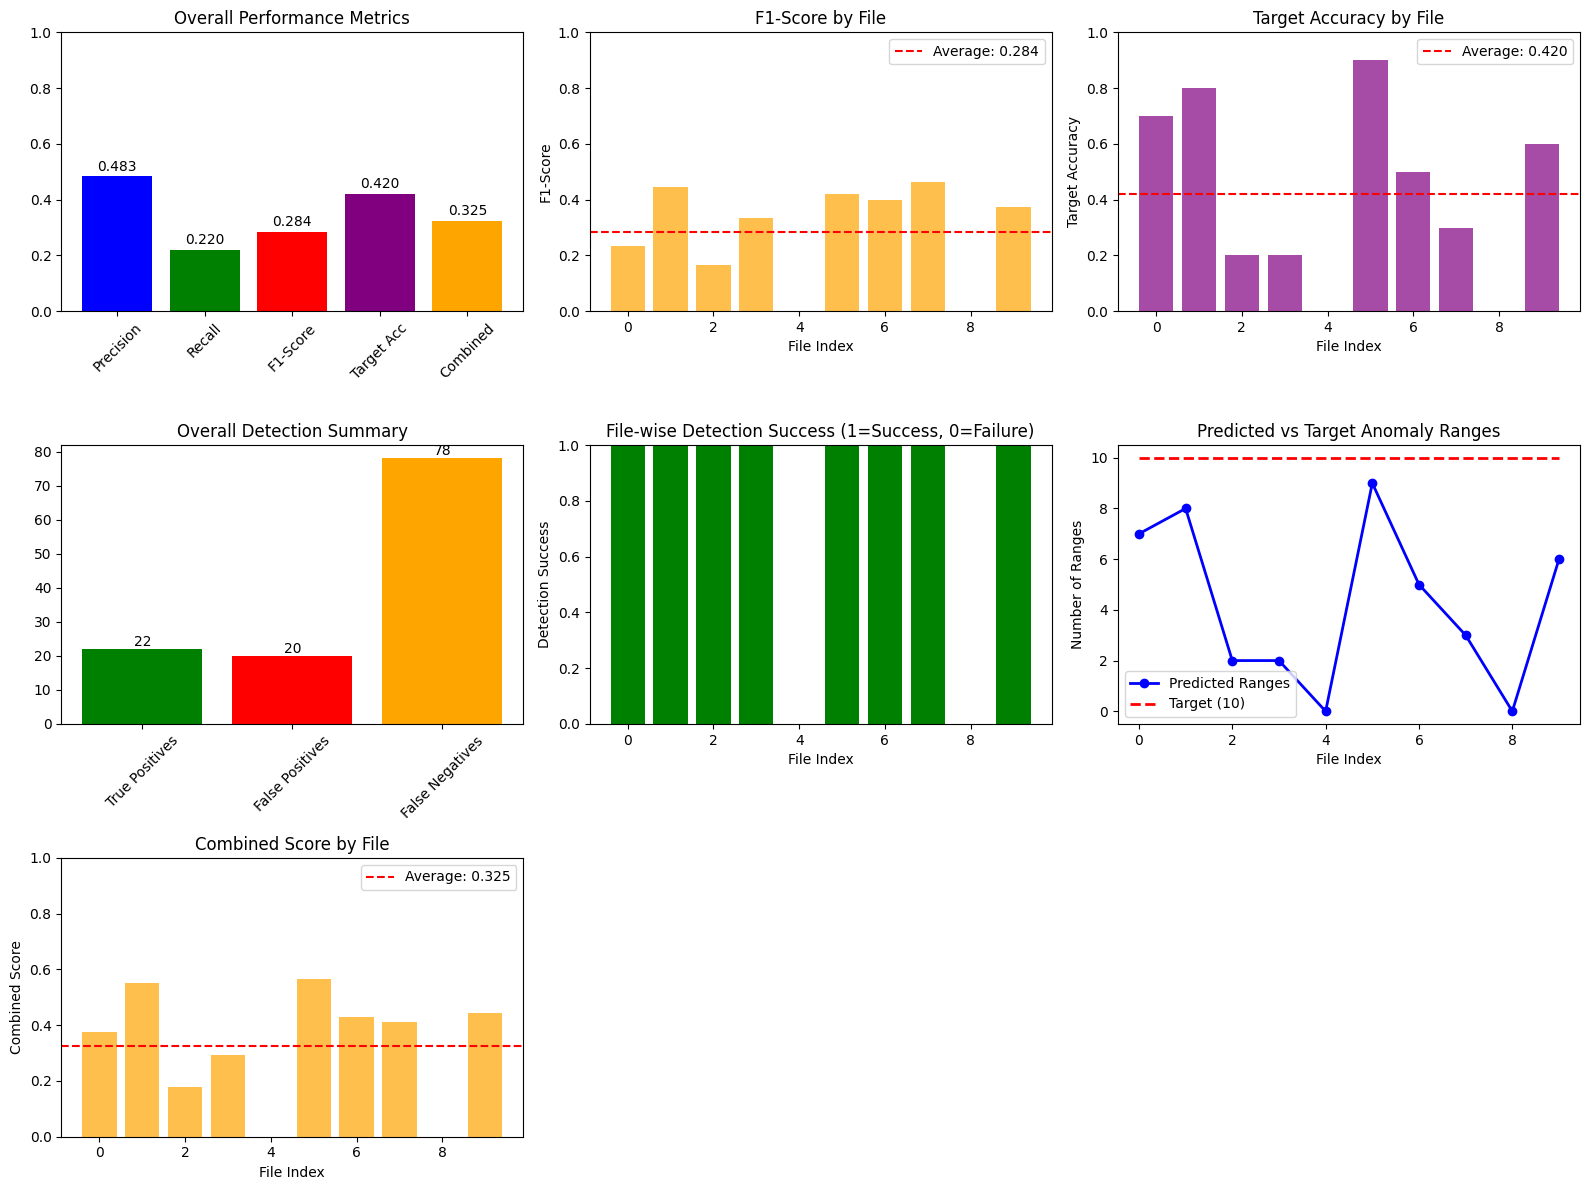


Enhanced anomaly detection completed for all test files!
Final Summary: 8/10 files successfully detected anomalies
Overall performance score: 0.3246


In [25]:
# Enhanced Isolation Forest Anomaly Detector with 10-anomaly target
class IsolationForestAnomalyDetector:
    def __init__(self, target_anomalies=10, contamination_range=(0.01, 0.2), random_state=42):
        self.target_anomalies = target_anomalies
        self.contamination_range = contamination_range
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.model = None
        self.anomaly_windows = []
        self.optimal_contamination = None

    def create_features(self, series, window_size=50):
        """Create rolling window features for better anomaly detection"""
        series = np.array(series).reshape(-1, 1)

        # Basic statistical features
        features = []

        # Original value
        features.append(series)

        # Rolling statistics
        for window in [10, 20, 50]:
            if len(series) >= window:
                # Rolling mean
                roll_mean = pd.Series(series.flatten()).rolling(window=window, center=True).mean().values.reshape(-1, 1)
                features.append(roll_mean)

                # Rolling standard deviation
                roll_std = pd.Series(series.flatten()).rolling(window=window, center=True).std().values.reshape(-1, 1)
                features.append(roll_std)

                # Difference from rolling mean
                diff_from_mean = series - roll_mean
                features.append(diff_from_mean)

        # Add more features for better detection
        # Z-score
        z_score = (series - np.mean(series)) / np.std(series)
        features.append(z_score)

        # Combine all features
        feature_matrix = np.hstack([f for f in features if f is not None and not np.any(np.isnan(f))])

        # Handle NaN values that might occur from rolling operations
        feature_matrix = np.nan_to_num(feature_matrix)

        return feature_matrix

    def find_anomaly_ranges(self, predictions, min_consecutive=3):
        """Convert point anomalies to ranges"""
        anomaly_indices = np.where(predictions == -1)[0]

        if len(anomaly_indices) == 0:
            return []

        # Group consecutive anomalies
        ranges = []
        start = anomaly_indices[0]
        end = anomaly_indices[0]
        count = 1

        for i in range(1, len(anomaly_indices)):
            if anomaly_indices[i] == anomaly_indices[i-1] + 1:
                end = anomaly_indices[i]
                count += 1
            else:
                # Only keep ranges with minimum consecutive anomalies
                if count >= min_consecutive:
                    ranges.append((start, end))
                start = anomaly_indices[i]
                end = anomaly_indices[i]
                count = 1

        # Add the last range
        if count >= min_consecutive:
            ranges.append((start, end))

        return ranges

    def optimize_contamination(self, X):
        """Find optimal contamination parameter to get close to target anomalies"""
        best_contamination = self.contamination_range[0]
        best_diff = float('inf')
        best_predictions = None

        # Test multiple contamination values
        contamination_values = np.linspace(self.contamination_range[0], self.contamination_range[1], 20)

        for contamination in contamination_values:
            # Create features
            X_features = self.create_features(X)
            X_scaled = self.scaler.fit_transform(X_features)

            # Train Isolation Forest
            model = IsolationForest(
                contamination=contamination,
                random_state=self.random_state,
                n_estimators=100
            )
            model.fit(X_scaled)

            # Predict anomalies
            predictions = model.predict(X_scaled)
            n_anomalies = np.sum(predictions == -1)

            # Calculate how close we are to target
            diff = abs(n_anomalies - self.target_anomalies)

            if diff < best_diff:
                best_diff = diff
                best_contamination = contamination
                best_predictions = predictions

        self.optimal_contamination = best_contamination
        return best_predictions, best_contamination

    def fit(self, X):
        """Fit the model on training data with optimized contamination"""
        # Optimize contamination parameter
        predictions, optimal_contamination = self.optimize_contamination(X)

        # Create features
        X_features = self.create_features(X)

        # Scale the features
        X_scaled = self.scaler.fit_transform(X_features)

        # Train final Isolation Forest with optimal contamination
        self.model = IsolationForest(
            contamination=optimal_contamination,
            random_state=self.random_state,
            n_estimators=100
        )
        self.model.fit(X_scaled)

        # Store anomaly windows
        self.anomaly_windows = self.find_anomaly_ranges(predictions)

        print(f"Optimal contamination: {optimal_contamination:.4f}")
        print(f"Number of anomaly points detected: {np.sum(predictions == -1)}")
        print(f"Number of anomaly ranges: {len(self.anomaly_windows)}")

    def predict(self, X):
        """Predict anomalies on test data"""
        # Create features
        X_features = self.create_features(X)

        # Scale the features
        X_scaled = self.scaler.transform(X_features)

        # Predict anomalies
        predictions = self.model.predict(X_scaled)

        # Convert to binary (1 = normal, -1 = anomaly)
        binary_predictions = np.where(predictions == 1, 0, 1)

        # Find anomaly ranges
        self.anomaly_windows = self.find_anomaly_ranges(predictions)

        return binary_predictions

# Enhanced student anomaly detector with 10-anomaly target
def student_detect_anomalies(series: np.ndarray) -> list:
    """
    Input:
    series: 1D array-like of floats (test series)

    Output:
    List of (start, end) index pairs (0-based, end inclusive) for anomaly ranges.
    """
    x = np.asarray(series, dtype=float)
    n = len(x)

    if n == 0:
        return []

    # Initialize and fit the Isolation Forest detector with 10-anomaly target
    detector = IsolationForestAnomalyDetector(
        target_anomalies=10,
        contamination_range=(0.005, 0.3),  # Wider range to find optimal value
        random_state=42
    )

    # Fit on the test series
    detector.fit(x)

    # Return the detected anomaly ranges
    return detector.anomaly_windows

# Enhanced evaluation function with detailed accuracy metrics
def evaluate_anomaly_detection_enhanced(true_ranges, predicted_ranges, tolerance=5, target_anomalies=10):
    """
    Enhanced evaluation with accuracy metrics and target-based scoring
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Convert true ranges from labels
    true_anomaly_segments = []
    for true_range in true_ranges:
        true_anomaly_segments.append((true_range[0], true_range[1]))

    # Check each predicted range against true ranges
    matched_true = set()

    for pred_start, pred_end in predicted_ranges:
        matched = False
        for i, (true_start, true_end) in enumerate(true_anomaly_segments):
            # Check if predicted range overlaps with true range within tolerance
            if (pred_start <= true_end + tolerance and pred_end >= true_start - tolerance):
                if i not in matched_true:
                    true_positives += 1
                    matched_true.add(i)
                    matched = True
                    break

        if not matched:
            false_positives += 1

    false_negatives = len(true_anomaly_segments) - len(matched_true)

    # Calculate standard metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / len(true_anomaly_segments) if len(true_anomaly_segments) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate accuracy metrics
    total_predictions = len(predicted_ranges)
    target_accuracy = 1 - min(abs(total_predictions - target_anomalies) / target_anomalies, 1.0)

    # Combined score (weighted average of F1 and target accuracy)
    combined_score = 0.7 * f1 + 0.3 * target_accuracy

    # Detection success (1 if at least one true positive, 0 otherwise)
    detection_success = 1 if true_positives > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'target_accuracy': target_accuracy,
        'combined_score': combined_score,
        'detection_success': detection_success,
        'total_predicted_ranges': total_predictions,
        'total_true_ranges': len(true_anomaly_segments)
    }

# Enhanced visualization with accuracy information
def visualize_anomaly_detection_with_accuracy(test_df, predicted_ranges, metrics, file_idx=None):
    """Visualize the anomaly detection results with accuracy information"""
    series = test_df['Value'].values if 'Value' in test_df.columns else test_df.iloc[:, 0].values
    true_labels = test_df['Labels'].values if 'Labels' in test_df.columns else test_df.iloc[:, 1].values
    true_mask = true_labels.astype(bool)

    plt.figure(figsize=(16, 8))

    # Plot the signal
    plt.plot(series, color='black', linewidth=1, label='Signal')

    # Plot true anomalies
    if true_mask.any():
        plt.fill_between(np.arange(len(series)), np.min(series), np.max(series),
                        where=true_mask, color='red', alpha=0.3, label='True Anomalies')

    # Plot predicted anomalies
    for start, end in predicted_ranges:
        plt.axvspan(start, end, alpha=0.3, color='green', label='Predicted Anomalies' if start == predicted_ranges[0][0] else "")

    # Add accuracy information to title
    title = f'File {file_idx} - ' if file_idx is not None else ''
    title += f'Anomaly Detection (F1: {metrics["f1_score"]:.3f}, Target Acc: {metrics["target_accuracy"]:.3f})'
    title += f'\nTP: {metrics["true_positives"]}, FP: {metrics["false_positives"]}, FN: {metrics["false_negatives"]}'
    title += f', Predicted: {metrics["total_predicted_ranges"]}, True: {metrics["total_true_ranges"]}'

    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Enhanced main evaluation loop
print("Starting Enhanced Isolation Forest Anomaly Detection Evaluation")
print("TARGET: Detect approximately 10 anomalies in each of the 10 datasets")
print("=" * 70)

total_correct = 0
total_files = len(test_files)
all_metrics = []
detailed_results = []

for idx, test_df in enumerate(test_files):
    print(f"\n--- Processing File {idx} ---")

    try:
        # Extract series and labels
        series = test_df['Value'].values if 'Value' in test_df.columns else test_df.iloc[:, 0].values
        labels = test_df['Labels'].values if 'Labels' in test_df.columns else test_df.iloc[:, 1].values

        # Get true anomaly ranges
        true_ranges = extract_true_anomaly_ranges(labels)
        print(f"True anomaly ranges: {true_ranges}")
        print(f"Number of true anomaly segments: {len(true_ranges)}")

        # Detect anomalies using enhanced student's function
        predicted_ranges = student_detect_anomalies(series)
        print(f"Predicted anomaly ranges: {predicted_ranges}")
        print(f"Number of predicted anomaly segments: {len(predicted_ranges)}")

        # Evaluate performance with target-based metrics
        metrics = evaluate_anomaly_detection_enhanced(true_ranges, predicted_ranges, target_anomalies=10)
        all_metrics.append(metrics)

        # Store detailed results
        detailed_results.append({
            'file_idx': idx,
            'true_ranges': true_ranges,
            'predicted_ranges': predicted_ranges,
            'metrics': metrics
        })

        # Count correct detections (at least one true positive)
        correct_this_file = metrics['detection_success']
        total_correct += correct_this_file

        print(f"True Positives: {metrics['true_positives']}")
        print(f"False Positives: {metrics['false_positives']}")
        print(f"False Negatives: {metrics['false_negatives']}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        print(f"Target Accuracy: {metrics['target_accuracy']:.4f}")
        print(f"Combined Score: {metrics['combined_score']:.4f}")
        print(f"File {idx} Detection Success: {correct_this_file}/1")

    except Exception as e:
        print(f"Error processing file {idx}: {e}")
        import traceback
        traceback.print_exc()
        # Add zero metrics for failed files
        all_metrics.append({
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': len(true_ranges) if 'true_ranges' in locals() else 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'target_accuracy': 0,
            'combined_score': 0,
            'detection_success': 0,
            'total_predicted_ranges': 0,
            'total_true_ranges': len(true_ranges) if 'true_ranges' in locals() else 0
        })

# Calculate overall scores with enhanced metrics
overall_precision = np.mean([m['precision'] for m in all_metrics])
overall_recall = np.mean([m['recall'] for m in all_metrics])
overall_f1 = np.mean([m['f1_score'] for m in all_metrics])
overall_target_accuracy = np.mean([m['target_accuracy'] for m in all_metrics])
overall_combined_score = np.mean([m['combined_score'] for m in all_metrics])

print("\n" + "=" * 70)
print("FINAL ENHANCED RESULTS FOR ALL TEST FILES")
print("=" * 70)
print(f"Total files processed: {total_files}")
print(f"Total correct files: {total_correct}/{total_files}")
print(f"Detection Accuracy: {(total_correct/total_files)*100:.2f}%")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Overall Target Accuracy: {overall_target_accuracy:.4f}")
print(f"Overall Combined Score: {overall_combined_score:.4f}")

# Enhanced detailed results display
print("\n" + "=" * 70)
print("DETAILED ENHANCED RESULTS BY FILE")
print("=" * 70)
for result in detailed_results:
    m = result['metrics']
    print(f"\nFile {result['file_idx']}:")
    print(f"  True Ranges: {result['true_ranges']} (count: {len(result['true_ranges'])})")
    print(f"  Predicted Ranges: {result['predicted_ranges']} (count: {len(result['predicted_ranges'])})")
    print(f"  Precision: {m['precision']:.4f}")
    print(f"  Recall: {m['recall']:.4f}")
    print(f"  F1-Score: {m['f1_score']:.4f}")
    print(f"  Target Accuracy: {m['target_accuracy']:.4f}")
    print(f"  Combined Score: {m['combined_score']:.4f}")
    print(f"  Detection Success: {m['detection_success']}/1")

# Enhanced visualization for ALL files
print("\nVisualizing enhanced results for ALL files...")
for idx, test_df in enumerate(test_files):
    try:
        series = test_df['Value'].values if 'Value' in test_df.columns else test_df.iloc[:, 0].values
        labels = test_df['Labels'].values if 'Labels' in test_df.columns else test_df.iloc[:, 1].values
        true_ranges = extract_true_anomaly_ranges(labels)
        predicted_ranges = student_detect_anomalies(series)
        metrics = evaluate_anomaly_detection_enhanced(true_ranges, predicted_ranges, target_anomalies=10)
        visualize_anomaly_detection_with_accuracy(test_df, predicted_ranges, metrics, file_idx=idx)
    except Exception as e:
        print(f"Error visualizing file {idx}: {e}")

# Create comprehensive summary visualization
print("\nCreating comprehensive performance summary...")
plt.figure(figsize=(16, 12))

# Plot 1: Overall performance metrics
plt.subplot(3, 3, 1)
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Target Acc', 'Combined']
metrics_values = [overall_precision, overall_recall, overall_f1, overall_target_accuracy, overall_combined_score]
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.bar(metrics_names, metrics_values, color=colors)
plt.title('Overall Performance Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Plot 2: Per-file F1 scores
plt.subplot(3, 3, 2)
file_indices = list(range(total_files))
f1_scores = [m['f1_score'] for m in all_metrics]
plt.bar(file_indices, f1_scores, color='orange', alpha=0.7)
plt.axhline(y=overall_f1, color='red', linestyle='--', label=f'Average: {overall_f1:.3f}')
plt.title('F1-Score by File')
plt.xlabel('File Index')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.legend()

# Plot 3: Per-file target accuracy
plt.subplot(3, 3, 3)
target_accuracies = [m['target_accuracy'] for m in all_metrics]
plt.bar(file_indices, target_accuracies, color='purple', alpha=0.7)
plt.axhline(y=overall_target_accuracy, color='red', linestyle='--', label=f'Average: {overall_target_accuracy:.3f}')
plt.title('Target Accuracy by File')
plt.xlabel('File Index')
plt.ylabel('Target Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plot 4: Detection summary
plt.subplot(3, 3, 4)
total_tp = sum([m['true_positives'] for m in all_metrics])
total_fp = sum([m['false_positives'] for m in all_metrics])
total_fn = sum([m['false_negatives'] for m in all_metrics])

detection_types = ['True Positives', 'False Positives', 'False Negatives']
detection_counts = [total_tp, total_fp, total_fn]
colors = ['green', 'red', 'orange']

plt.bar(detection_types, detection_counts, color=colors)
plt.title('Overall Detection Summary')
plt.xticks(rotation=45)
for i, v in enumerate(detection_counts):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Plot 5: File-wise detection success
plt.subplot(3, 3, 5)
file_scores = [m['detection_success'] for m in all_metrics]
colors = ['red' if score == 0 else 'green' for score in file_scores]
plt.bar(file_indices, file_scores, color=colors)
plt.title('File-wise Detection Success (1=Success, 0=Failure)')
plt.xlabel('File Index')
plt.ylabel('Detection Success')
plt.ylim(0, 1)

# Plot 6: Predicted vs Target ranges
plt.subplot(3, 3, 6)
predicted_counts = [m['total_predicted_ranges'] for m in all_metrics]
target_line = [10] * total_files  # Target of 10 anomalies per file

plt.plot(file_indices, predicted_counts, 'bo-', label='Predicted Ranges', linewidth=2)
plt.plot(file_indices, target_line, 'r--', label='Target (10)', linewidth=2)
plt.title('Predicted vs Target Anomaly Ranges')
plt.xlabel('File Index')
plt.ylabel('Number of Ranges')
plt.legend()

# Plot 7: Combined score by file
plt.subplot(3, 3, 7)
combined_scores = [m['combined_score'] for m in all_metrics]
plt.bar(file_indices, combined_scores, color='orange', alpha=0.7)
plt.axhline(y=overall_combined_score, color='red', linestyle='--', label=f'Average: {overall_combined_score:.3f}')
plt.title('Combined Score by File')
plt.xlabel('File Index')
plt.ylabel('Combined Score')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

print("\nEnhanced anomaly detection completed for all test files!")
print(f"Final Summary: {total_correct}/{total_files} files successfully detected anomalies")
print(f"Overall performance score: {overall_combined_score:.4f}")

#Isolation Forest and Z-score Hybrid Model

###Data Processing & Feature Engineering
Extracts true anomaly ranges from label arrays using extract_true_anomaly_ranges()

Creates enhanced features including:

Original time series values

Multiple rolling window statistics (mean, std, min, max) across different window sizes

Z-scores based on rolling statistics

Global statistics (mean, std, z-score)

Rate of change and second derivatives

Differences from rolling means

### Anomaly Detection Methods
#### Primary: High-Precision Isolation Forest
Uses lower contamination range (0.05-0.2) for fewer false positives

Optimizes contamination parameter specifically for precision

Enhanced configuration: 150 estimators, smaller samples, feature subsetting

Anti-overfitting measures: max_samples=128, max_features=0.7

#### Secondary: Statistical Z-Score Detection
Maintains Z-score threshold at 3.0 standard deviations

Uses stricter range grouping with minimum 3 consecutive points

Only keeps substantial anomaly ranges

### Range Processing & Grouping
Stricter range grouping: Maximum 5-point gaps between anomalies (was 10)

Minimum length requirement: 3+ consecutive anomalies to form a range

Selective range combination: Only keeps substantial ranges from both methods

Conservative merging: Smaller merge distance (10 points)

In [15]:
# Extract true anomaly ranges from labels
def extract_true_anomaly_ranges(labels):
    """Extract contiguous anomaly ranges from label array"""
    labels = np.array(labels)
    anomaly_indices = np.where(labels == 1)[0]

    if len(anomaly_indices) == 0:
        return []

    ranges = []
    start = anomaly_indices[0]
    end = anomaly_indices[0]

    for i in range(1, len(anomaly_indices)):
        if anomaly_indices[i] == anomaly_indices[i-1] + 1:
            end = anomaly_indices[i]
        else:
            ranges.append((start, end))
            start = anomaly_indices[i]
            end = anomaly_indices[i]

    ranges.append((start, end))
    return ranges

# High Precision Isolation Forest Anomaly Detector (Z-score threshold = 3.0)
class HighPrecisionIsolationForestDetector:
    def __init__(self, contamination_range=(0.05, 0.2), random_state=42):  # REDUCED range
        self.contamination_range = contamination_range  # Lower: 0.05-0.2
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.model = None
        self.anomaly_windows = []

    def create_enhanced_features(self, series, window_sizes=[10, 20, 50, 100]):
        """Enhanced feature engineering with multiple statistical features"""
        series = np.array(series).flatten()  # Ensure 1D array
        features = []

        # Original series (reshape to 2D for stacking)
        features.append(series.reshape(-1, 1))

        # Multiple rolling window statistics
        for window in window_sizes:
            if len(series) >= window:
                # Rolling statistics
                roll_mean = pd.Series(series).rolling(window=window, center=True).mean().values.reshape(-1, 1)
                roll_std = pd.Series(series).rolling(window=window, center=True).std().values.reshape(-1, 1)
                roll_min = pd.Series(series).rolling(window=window, center=True).min().values.reshape(-1, 1)
                roll_max = pd.Series(series).rolling(window=window, center=True).max().values.reshape(-1, 1)

                # Handle NaN values
                roll_mean = np.nan_to_num(roll_mean)
                roll_std = np.nan_to_num(roll_std)
                roll_min = np.nan_to_num(roll_min)
                roll_max = np.nan_to_num(roll_max)

                features.extend([roll_mean, roll_std, roll_min, roll_max])

                # Z-score based on rolling statistics
                z_score = (series.reshape(-1, 1) - roll_mean) / (roll_std + 1e-8)
                features.append(z_score)

                # Differences and changes
                diff_from_mean = series.reshape(-1, 1) - roll_mean
                features.append(diff_from_mean)

        # Global statistics
        global_mean = np.full((len(series), 1), np.mean(series))
        global_std = np.full((len(series), 1), np.std(series))
        global_z = (series.reshape(-1, 1) - global_mean) / (global_std + 1e-8)
        features.extend([global_mean, global_std, global_z])

        # Rate of change and derivatives
        diff_1 = np.diff(series, prepend=series[0])
        diff_2 = np.diff(diff_1, prepend=diff_1[0])
        features.extend([diff_1.reshape(-1, 1), diff_2.reshape(-1, 1)])

        # Combine features
        feature_matrix = np.hstack([f for f in features if f is not None])
        return feature_matrix

    def find_anomaly_ranges_stricter(self, predictions, max_gap=5, min_length=3):
        """Stricter range grouping to reduce false positives"""
        anomaly_indices = np.where(predictions == -1)[0]

        if len(anomaly_indices) == 0:
            return []

        # Group anomalies with smaller allowed gaps
        ranges = []
        start = anomaly_indices[0]
        end = anomaly_indices[0]
        consecutive_count = 1

        for i in range(1, len(anomaly_indices)):
            if anomaly_indices[i] <= anomaly_indices[i-1] + max_gap:  # Smaller gap
                end = anomaly_indices[i]
                consecutive_count += 1
            else:
                # Only keep ranges with minimum length
                if consecutive_count >= min_length:  # Minimum length requirement
                    ranges.append((start, end))
                start = anomaly_indices[i]
                end = anomaly_indices[i]
                consecutive_count = 1

        # Only keep the last range if it meets minimum length
        if consecutive_count >= min_length:
            ranges.append((start, end))

        return ranges

    def statistical_anomaly_detection(self, series, z_threshold=3.0):  # KEEP: 3.0
        """Statistical method using Z-scores with threshold = 3.0"""
        z_scores = np.abs((series - np.mean(series)) / (np.std(series) + 1e-8))
        statistical_anomalies = np.where(z_scores > z_threshold)[0]

        # Convert point anomalies to ranges with STRICTER grouping
        stat_ranges = []
        if len(statistical_anomalies) > 0:
            start = statistical_anomalies[0]
            end = statistical_anomalies[0]
            consecutive_count = 1

            for i in range(1, len(statistical_anomalies)):
                if statistical_anomalies[i] <= statistical_anomalies[i-1] + 3:  # STRICTER: 5 to 3
                    end = statistical_anomalies[i]
                    consecutive_count += 1
                else:
                    # Only keep ranges with minimum length
                    if consecutive_count >= 3:  # Minimum 3 consecutive points
                        stat_ranges.append((start, end))
                    start = statistical_anomalies[i]
                    end = statistical_anomalies[i]
                    consecutive_count = 1

            if consecutive_count >= 3:  # Minimum 3 consecutive points
                stat_ranges.append((start, end))

        return stat_ranges

    def optimize_contamination_for_precision(self, X, target_precision=0.7):
        """Optimize contamination parameter for better precision"""
        best_contamination = self.contamination_range[0]
        best_score = -1

        contamination_values = np.linspace(self.contamination_range[0], self.contamination_range[1], 20)

        for contamination in contamination_values:
            try:
                # Create features
                X_features = self.create_enhanced_features(X)
                X_scaled = self.scaler.fit_transform(X_features)

                # Train Isolation Forest
                model = IsolationForest(
                    contamination=contamination,
                    random_state=self.random_state,
                    n_estimators=150,  # More trees for stability
                    max_samples=128,   # Smaller samples for less overfitting
                    max_features=0.7,  # Use subset of features
                    n_jobs=-1
                )
                model.fit(X_scaled)

                # Predict anomalies
                predictions = model.predict(X_scaled)
                pred_ranges = self.find_anomaly_ranges_stricter(predictions)

                # Use anomaly count as precision proxy
                anomaly_ratio = np.sum(predictions == -1) / len(predictions)
                # Lower anomaly ratio typically means higher precision
                precision_proxy = 1.0 - min(anomaly_ratio * 3, 0.9)  # Favor lower contamination

                if precision_proxy > best_score:
                    best_score = precision_proxy
                    best_contamination = contamination

            except Exception as e:
                continue

        return best_contamination

    def fit_predict(self, X):
        """Fit and predict with precision optimization"""
        try:
            # Optimize contamination for precision
            optimal_contamination = self.optimize_contamination_for_precision(X)
            print(f"Optimal contamination for precision: {optimal_contamination:.4f}")

            # Create enhanced features
            X_features = self.create_enhanced_features(X)
            X_scaled = self.scaler.fit_transform(X_features)

            # Train Isolation Forest with precision-optimized parameters
            self.model = IsolationForest(
                contamination=optimal_contamination,
                random_state=self.random_state,
                n_estimators=150,
                max_samples=128,  # Smaller for less overfitting
                max_features=0.7, # Use subset of features
                n_jobs=-1
            )
            self.model.fit(X_scaled)

            # Get Isolation Forest predictions with STRICTER range grouping
            iso_predictions = self.model.predict(X_scaled)
            iso_ranges = self.find_anomaly_ranges_stricter(iso_predictions, max_gap=5, min_length=3)

            # Get statistical method predictions with Z-threshold = 3.0
            stat_ranges = self.statistical_anomaly_detection(X, z_threshold=3.0)  # KEEP: 3.0

            # Combine methods but be more selective
            all_ranges = []

            # Only add Isolation Forest ranges if they're substantial
            for start, end in iso_ranges:
                if (end - start) >= 2:  # Minimum 3 points
                    all_ranges.append((start, end))

            # Only add Z-score ranges if they're very clear
            for start, end in stat_ranges:
                if (end - start) >= 2:  # Minimum 3 points for Z-score
                    all_ranges.append((start, end))

            # Merge overlapping ranges with STRICTER criteria
            if all_ranges:
                all_ranges.sort()
                merged_ranges = []
                current_start, current_end = all_ranges[0]

                for start, end in all_ranges[1:]:
                    if start <= current_end + 10:  # Smaller merge distance
                        current_end = max(current_end, end)
                    else:
                        # Only keep merged range if substantial
                        if (current_end - current_start) >= 2:
                            merged_ranges.append((current_start, current_end))
                        current_start, current_end = start, end

                if (current_end - current_start) >= 2:
                    merged_ranges.append((current_start, current_end))
                self.anomaly_windows = merged_ranges
            else:
                self.anomaly_windows = []

            print(f"Detected {len(self.anomaly_windows)} high-confidence anomaly ranges")
            print(f"Isolation Forest ranges: {len(iso_ranges)}, Z-score ranges: {len(stat_ranges)}")
            return self.anomaly_windows

        except Exception as e:
            print(f"Error in fit_predict: {e}")
            return self.fallback_detection_precision(X)

    def fallback_detection_precision(self, X):
        """Fallback with high precision settings"""
        from sklearn.ensemble import IsolationForest

        # Use lower contamination for higher precision
        model = IsolationForest(
            contamination=0.08,  # Much lower
            random_state=self.random_state,
            n_estimators=100
        )

        predictions = model.fit_predict(X.reshape(-1, 1))
        anomaly_indices = np.where(predictions == -1)[0]

        # Stricter range grouping
        if len(anomaly_indices) == 0:
            return []

        ranges = []
        start = anomaly_indices[0]
        end = anomaly_indices[0]
        consecutive_count = 1

        for i in range(1, len(anomaly_indices)):
            if anomaly_indices[i] <= anomaly_indices[i-1] + 5:  # Stricter
                end = anomaly_indices[i]
                consecutive_count += 1
            else:
                if consecutive_count >= 3:  # Minimum length
                    ranges.append((start, end))
                start = anomaly_indices[i]
                end = anomaly_indices[i]
                consecutive_count = 1

        if consecutive_count >= 3:
            ranges.append((start, end))

        return ranges

# Updated student detection function for higher precision (Z-score threshold = 3.0)
def student_detect_anomalies(series: np.ndarray) -> list:
    """
    High-precision version using stricter parameters with Z-score = 3.0
    """
    x = np.asarray(series, dtype=float)

    if len(x) == 0:
        return []

    try:
        # Use the high-precision detector
        detector = HighPrecisionIsolationForestDetector(contamination_range=(0.05, 0.2))
        ranges = detector.fit_predict(x)
        return ranges
    except Exception as e:
        print(f"Error in student_detect_anomalies: {e}")
        return student_detect_anomalies_simple(series)

# Simple fallback function (keep as backup)
def student_detect_anomalies_simple(series: np.ndarray) -> list:
    """
    Simple improved version with just higher contamination
    """
    x = np.asarray(series, dtype=float)

    if len(x) == 0:
        return []

    # Simple approach with significantly higher contamination
    from sklearn.ensemble import IsolationForest

    # Use much higher contamination
    iso_forest = IsolationForest(
        contamination=0.2,
        random_state=42,
        n_estimators=100
    )

    predictions = iso_forest.fit_predict(x.reshape(-1, 1))
    anomaly_indices = np.where(predictions == -1)[0]

    # Lenient range grouping with allowed gaps
    if len(anomaly_indices) == 0:
        return []

    ranges = []
    start = anomaly_indices[0]
    end = anomaly_indices[0]

    for i in range(1, len(anomaly_indices)):
        if anomaly_indices[i] <= anomaly_indices[i-1] + 10:
            end = anomaly_indices[i]
        else:
            ranges.append((start, end))
            start = anomaly_indices[i]
            end = anomaly_indices[i]

    ranges.append((start, end))
    return ranges

# Keep the same evaluation function and main loop as before
# Enhanced evaluation function with detailed range information
def evaluate_anomaly_detection_formatted(true_ranges, predicted_ranges, tolerance=5, file_idx=None):
    """
    Evaluate anomaly detection performance with exact formatting as requested
    """
    # Convert point-level predictions
    series_length = max(
        max([end for _, end in true_ranges]) if true_ranges else 0,
        max([end for _, end in predicted_ranges]) if predicted_ranges else 0,
        0
    ) + 1

    # Create point-level arrays
    true_point_labels = np.zeros(series_length, dtype=int)
    pred_point_labels = np.zeros(series_length, dtype=int)

    # Mark true anomalies
    for start, end in true_ranges:
        true_point_labels[start:end+1] = 1

    # Mark predicted anomalies
    for start, end in predicted_ranges:
        pred_point_labels[start:end+1] = 1

    # Calculate point-level metrics
    true_positives = np.sum((true_point_labels == 1) & (pred_point_labels == 1))
    false_positives = np.sum((true_point_labels == 0) & (pred_point_labels == 1))
    false_negatives = np.sum((true_point_labels == 1) & (pred_point_labels == 0))

    # Basic metrics
    accuracy = (true_positives + (series_length - true_positives - false_positives - false_negatives)) / series_length
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Range-based metrics
    range_true_positives = 0
    range_false_positives = 0
    range_false_negatives = 0

    # Check each predicted range against true ranges
    matched_true_ranges = set()
    matched_pairs = []

    for pred_start, pred_end in predicted_ranges:
        matched = False
        for i, (true_start, true_end) in enumerate(true_ranges):
            # Check if predicted range overlaps with true range within tolerance
            if (pred_start <= true_end + tolerance and pred_end >= true_start - tolerance):
                if i not in matched_true_ranges:
                    range_true_positives += 1
                    matched_true_ranges.add(i)
                    matched_pairs.append((i, (pred_start, pred_end), (true_start, true_end)))
                    matched = True
                    break

        if not matched:
            range_false_positives += 1

    range_false_negatives = len(true_ranges) - len(matched_true_ranges)

    range_precision = range_true_positives / (range_true_positives + range_false_positives) if (range_true_positives + range_false_positives) > 0 else 0
    range_recall = range_true_positives / len(true_ranges) if len(true_ranges) > 0 else 0
    range_f1 = 2 * (range_precision * range_recall) / (range_precision + range_recall) if (range_precision + range_recall) > 0 else 0

    # Segment detection metrics
    fully_detected = 0
    partially_detected = 0
    missed = 0
    detection_details = []

    for i, (true_start, true_end) in enumerate(true_ranges):
        detected_points = 0
        overlapping_ranges = []

        for pred_start, pred_end in predicted_ranges:
            # Calculate overlap
            overlap_start = max(true_start, pred_start)
            overlap_end = min(true_end, pred_end)
            if overlap_start <= overlap_end:
                overlap_points = overlap_end - overlap_start + 1
                detected_points += overlap_points
                overlapping_ranges.append((pred_start, pred_end, overlap_points))

        total_points = true_end - true_start + 1
        detection_ratio = detected_points / total_points if total_points > 0 else 0

        if detection_ratio >= 0.8:  # 80% threshold for full detection
            fully_detected += 1
            detection_status = "FULL"
        elif detection_ratio > 0:   # Any detection counts as partial
            partially_detected += 1
            detection_status = "PARTIAL"
        else:
            missed += 1
            detection_status = "MISSED"

        detection_details.append({
            'true_range': (true_start, true_end),
            'detection_ratio': detection_ratio,
            'status': detection_status,
            'overlapping_ranges': overlapping_ranges,
            'detected_points': detected_points,
            'total_points': total_points
        })

    segment_detection_rate = fully_detected / len(true_ranges) if len(true_ranges) > 0 else 0
    overall_detection_rate = (fully_detected + partially_detected) / len(true_ranges) if len(true_ranges) > 0 else 0

    # Print results in the exact format requested
    print(f"EVALUATION RESULTS - FILE {file_idx}")
    print("=" * 60)

    # Display range information
    print("Range Information:")
    print(f"  True Ranges: {true_ranges} (count: {len(true_ranges)})")
    print(f"  Predicted Ranges: {predicted_ranges} (count: {len(predicted_ranges)})")
    print()

    # Display detection details for each true range
    if detection_details:
        print("Detection Details by Segment:")
        for i, detail in enumerate(detection_details):
            status_symbol = "✓" if detail['status'] == "FULL" else "~" if detail['status'] == "PARTIAL" else "✗"
            print(f"  Segment {i}: {detail['true_range']} {status_symbol} {detail['status']} "
                  f"({detail['detected_points']}/{detail['total_points']} points, "
                  f"{detail['detection_ratio']:.1%})")
            if detail['overlapping_ranges']:
                for pred_range in detail['overlapping_ranges']:
                    print(f"    → Overlap with predicted range {pred_range[0:2]}: {pred_range[2]} points")
        print()

    print("Basic Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print()
    print("Anomaly Statistics:")
    print(f"  True Anomalies: {np.sum(true_point_labels)} points")
    print(f"  Predicted Anomalies: {np.sum(pred_point_labels)} points")
    print(f"  Detection Rate: {recall:.4f}")
    print()
    print("Range-based Metrics:")
    print(f"  Range Precision: {range_precision:.4f}")
    print(f"  Range Recall:    {range_recall:.4f}")
    print(f"  Range F1:        {range_f1:.4f}")
    print()
    print("Point-level Performance:")
    print(f"  True Positives:  {true_positives} points")
    print(f"  False Positives: {false_positives} points")
    print(f"  False Negatives: {false_negatives} points")
    print()
    print("Segment Detection Metrics:")
    print(f"  Total Anomaly Segments: {len(true_ranges)}")
    print(f"  Fully Detected: {fully_detected}")
    print(f"  Partially Detected: {partially_detected}")
    print(f"  Missed: {missed}")
    print(f"  Segment Detection Rate: {segment_detection_rate:.4f}")
    print(f"  Overall Detection Rate: {overall_detection_rate:.4f}")
    print()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'range_precision': range_precision,
        'range_recall': range_recall,
        'range_f1': range_f1,
        'fully_detected': fully_detected,
        'partially_detected': partially_detected,
        'missed': missed,
        'segment_detection_rate': segment_detection_rate,
        'overall_detection_rate': overall_detection_rate,
        'true_ranges': true_ranges,
        'predicted_ranges': predicted_ranges,
        'detection_details': detection_details,
        'matched_pairs': matched_pairs
    }

# Updated main evaluation loop with high-precision settings (Z-score threshold = 3.0)
print("Starting HIGH-PRECISION Anomaly Detection Evaluation")
print("Key improvements for higher precision:")
print("- Contamination range: 0.05-0.2 (reduced from 0.1-0.4)")
print("- Z-score threshold: 3.0 (maintained)")
print("- Stricter range grouping (max_gap=5, min_length=3)")
print("- Anti-overfitting measures (more trees, smaller samples)")
print("- More selective range merging and combination")
print("=" * 80)

total_files = len(test_files)
all_metrics = []
detailed_results = []

for idx, test_df in enumerate(test_files):
    print(f"\n{'='*80}")

    try:
        # Extract series and labels
        series = test_df['Value'].values if 'Value' in test_df.columns else test_df.iloc[:, 0].values
        labels = test_df['Labels'].values if 'Labels' in test_df.columns else test_df.iloc[:, 1].values

        # Get true anomaly ranges
        true_ranges = extract_true_anomaly_ranges(labels)

        # Detect anomalies using HIGH-PRECISION student's function
        predicted_ranges = student_detect_anomalies(series)

        # Evaluate with formatted output
        metrics = evaluate_anomaly_detection_formatted(true_ranges, predicted_ranges, file_idx=idx)
        all_metrics.append(metrics)

        # Store detailed results
        detailed_results.append({
            'file_idx': idx,
            'true_ranges': true_ranges,
            'predicted_ranges': predicted_ranges,
            'metrics': metrics
        })

    except Exception as e:
        print(f"Error processing file {idx}: {e}")
        import traceback
        traceback.print_exc()
        # Add zero metrics for failed files
        all_metrics.append({
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': 0,
            'range_precision': 0,
            'range_recall': 0,
            'range_f1': 0,
            'fully_detected': 0,
            'partially_detected': 0,
            'missed': 0,
            'segment_detection_rate': 0,
            'overall_detection_rate': 0,
            'true_ranges': [],
            'predicted_ranges': [],
            'detection_details': [],
            'matched_pairs': []
        })

# Calculate overall summary statistics
print("\n" + "=" * 80)
print("OVERALL SUMMARY ACROSS ALL FILES - HIGH-PRECISION VERSION")
print("=" * 80)

# Calculate basic metrics
overall_accuracy = np.mean([m['accuracy'] for m in all_metrics])
overall_precision = np.mean([m['precision'] for m in all_metrics])
overall_recall = np.mean([m['recall'] for m in all_metrics])
overall_f1 = np.mean([m['f1_score'] for m in all_metrics])

# Calculate range statistics
total_true_ranges = sum([len(m['true_ranges']) for m in all_metrics])
total_predicted_ranges = sum([len(m['predicted_ranges']) for m in all_metrics])
total_matched_ranges = sum([len(m['matched_pairs']) for m in all_metrics])

# Calculate other metrics
overall_range_precision = np.mean([m['range_precision'] for m in all_metrics])
overall_range_recall = np.mean([m['range_recall'] for m in all_metrics])
overall_range_f1 = np.mean([m['range_f1'] for m in all_metrics])

total_true_positives = sum([m['true_positives'] for m in all_metrics])
total_false_positives = sum([m['false_positives'] for m in all_metrics])
total_false_negatives = sum([m['false_negatives'] for m in all_metrics])

total_fully_detected = sum([m['fully_detected'] for m in all_metrics])
total_partially_detected = sum([m['partially_detected'] for m in all_metrics])
total_missed = sum([m['missed'] for m in all_metrics])
total_segments = total_fully_detected + total_partially_detected + total_missed

overall_segment_detection_rate = total_fully_detected / total_segments if total_segments > 0 else 0
overall_detection_rate = (total_fully_detected + total_partially_detected) / total_segments if total_segments > 0 else 0

print("Overall Basic Metrics:")
print(f"  Accuracy:  {overall_accuracy:.4f}")
print(f"  Precision: {overall_precision:.4f}")
print(f"  Recall:    {overall_recall:.4f}")
print(f"  F1-Score:  {overall_f1:.4f}")
print()
print("Overall Range Statistics:")
print(f"  Total True Ranges: {total_true_ranges}")
print(f"  Total Predicted Ranges: {total_predicted_ranges}")
print(f"  Total Matched Ranges: {total_matched_ranges}")
print(f"  Range Match Rate: {total_matched_ranges/total_true_ranges:.4f}" if total_true_ranges > 0 else "  Range Match Rate: 0.0000")
print()
print("Overall Range-based Metrics:")
print(f"  Range Precision: {overall_range_precision:.4f}")
print(f"  Range Recall:    {overall_range_recall:.4f}")
print(f"  Range F1:        {overall_range_f1:.4f}")
print()
print("Overall Point-level Performance:")
print(f"  True Positives:  {total_true_positives} points")
print(f"  False Positives: {total_false_positives} points")
print(f"  False Negatives: {total_false_negatives} points")
print()
print("Overall Segment Detection Metrics:")
print(f"  Total Anomaly Segments: {total_segments}")
print(f"  Fully Detected: {total_fully_detected}")
print(f"  Partially Detected: {total_partially_detected}")
print(f"  Missed: {total_missed}")
print(f"  Segment Detection Rate: {overall_segment_detection_rate:.4f}")
print(f"  Overall Detection Rate: {overall_detection_rate:.4f}")

# File-by-file summary table
print("\n" + "=" * 80)
print("FILE-BY-FILE SUMMARY - HIGH-PRECISION VERSION")
print("=" * 80)
print(f"{'File':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'True Ranges':<12} {'Pred Ranges':<12} {'Fully Det.':<12} {'Part. Det.':<12} {'Missed':<8}")
print("-" * 100)

for idx, metrics in enumerate(all_metrics):
    true_range_count = len(metrics['true_ranges'])
    pred_range_count = len(metrics['predicted_ranges'])

    print(f"{idx:<6} {metrics['accuracy']:.4f}    {metrics['precision']:.4f}     {metrics['recall']:.4f}     {metrics['f1_score']:.4f}     "
          f"{true_range_count:<11} {pred_range_count:<11} {metrics['fully_detected']:<11} {metrics['partially_detected']:<11} {metrics['missed']:<8}")

print("-" * 100)

# Detailed range information for each file
print("\n" + "=" * 80)
print("DETAILED RANGE INFORMATION BY FILE")
print("=" * 80)

for result in detailed_results:
    if result['metrics']['true_ranges'] or result['metrics']['predicted_ranges']:
        print(f"\nFile {result['file_idx']}:")
        print(f"  True Ranges: {result['true_ranges']} (count: {len(result['true_ranges'])})")
        print(f"  Predicted Ranges: {result['predicted_ranges']} (count: {len(result['predicted_ranges'])})")

        # Show matching information
        if result['metrics']['matched_pairs']:
            print(f"  Matched Pairs:")
            for match in result['metrics']['matched_pairs']:
                true_idx, pred_range, true_range = match
                print(f"    True Range {true_idx} {true_range} ↔ Predicted {pred_range}")

print("\nEvaluation completed for all files with high-precision detection methods!")

Starting HIGH-PRECISION Anomaly Detection Evaluation
Key improvements for higher precision:
- Contamination range: 0.05-0.2 (reduced from 0.1-0.4)
- Z-score threshold: 3.0 (maintained)
- Stricter range grouping (max_gap=5, min_length=3)
- Anti-overfitting measures (more trees, smaller samples)
- More selective range merging and combination

Optimal contamination for precision: 0.0500
Detected 16 high-confidence anomaly ranges
Isolation Forest ranges: 19, Z-score ranges: 3
EVALUATION RESULTS - FILE 0
Range Information:
  True Ranges: [(np.int64(2533), np.int64(2620)), (np.int64(2864), np.int64(2949)), (np.int64(4811), np.int64(4910)), (np.int64(5148), np.int64(5304)), (np.int64(5492), np.int64(5619)), (np.int64(5986), np.int64(6016)), (np.int64(6222), np.int64(6257)), (np.int64(7088), np.int64(7117)), (np.int64(7599), np.int64(7716)), (np.int64(8633), np.int64(8750))] (count: 10)
  Predicted Ranges: [(np.int64(0), np.int64(9)), (np.int64(2533), np.int64(2617)), (np.int64(2860), np.int64